# ETAD Site: Comprehensive Absorption Analysis

This notebook performs detailed analysis of absorption measurements comparing:
- HIPS Fabs vs Aethalometer Babs (calculated from BCc using σATN)
- BCc vs FTIR EC correlations
- BCc vs Iron correlations  
- Time series analysis

Uses the modular AethalometerFilterMatcher system for data loading and matching.

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import warnings
warnings.filterwarnings('ignore')

# Import the modular matcher
sys.path.append('..')
from src.data.loaders import AethalometerFilterMatcher

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


In [2]:
# Define wavelength-specific attenuation cross-sections (σATN)
SIGMA_ATN = {
    'IR': 10.120,      # 880 nm
    'Red': 14.091,     # 625 nm  
    'Green': 17.028,   # 528 nm
    'Blue': 19.070,    # 470 nm
    'UV': 24.069       # 375 nm
}

print("📊 Wavelength-specific attenuation cross-sections (σATN):")
for wavelength, sigma in SIGMA_ATN.items():
    print(f"   {wavelength}: {sigma} m²/g")

📊 Wavelength-specific attenuation cross-sections (σATN):
   IR: 10.12 m²/g
   Red: 14.091 m²/g
   Green: 17.028 m²/g
   Blue: 19.07 m²/g
   UV: 24.069 m²/g


In [3]:
# Load and match data using the modular system
aethalometer_path = "../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl"
filter_db_path = "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl"

print("🔗 Loading and matching ETAD data...")

# Create matcher and load data
matcher = AethalometerFilterMatcher(aethalometer_path, filter_db_path)

# Match ETAD data with all parameters
matched_data = matcher.match_site_data(
    'ETAD',
    filter_parameters=['EC_ftir', 'HIPS_Fabs', 'ChemSpec_Iron_PM2.5'],
    aethalometer_columns=[
        'IR BCc smoothed', 'Red BCc smoothed', 
        'Green BCc smoothed', 'Blue BCc smoothed', 'UV BCc smoothed'
    ]
)

print(f"\n✅ Data matching complete! Shape: {matched_data.shape}")

🔗 Loading and matching ETAD data...
Loading complete filter dataset from ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded from: ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
🔗 Matching aethalometer and filter data for ETAD...
✅ Aethalometer data loaded from: ../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
   Dataset shape: (1047, 320)
   Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
   No 'Site' column found - assuming single site data
📍 No 'Site' column - assuming all data is for ETAD
📂 Extracting ETAD filter measurements...
   ✅ EC_ftir: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ HIPS_Fabs: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ Iron_ChemSpec: 188 measurements
      Date range: 20

## 2. Calculate Absorption Coefficients (Babs)

In [4]:
# Convert BCc from ng/m³ to μg/m³ and calculate Babs
print("🔄 Converting BCc units from ng/m³ to μg/m³ and calculating Babs...")

# First, check the magnitude of BCc values to determine units
bc_sample_cols = [col for col in matched_data.columns if 'BCc smoothed' in col]
if bc_sample_cols:
    sample_col = bc_sample_cols[0]
    sample_values = matched_data[sample_col].dropna()
    if len(sample_values) > 0:
        mean_val = sample_values.mean()
        print(f"📊 Original BCc values: Mean = {mean_val:.3f} (from {sample_col})")
        
        # Convert all BCc columns from ng/m³ to μg/m³
        print("🔄 Converting all BCc columns from ng/m³ to μg/m³...")
        
        for col in bc_sample_cols:
            if col in matched_data.columns:
                # Convert ng/m³ to μg/m³ by dividing by 1000
                original_mean = matched_data[col].mean()
                matched_data[col] = matched_data[col] / 1000.0  # ng/m³ → μg/m³
                converted_mean = matched_data[col].mean()
                
                print(f"   {col}:")
                print(f"     Before: {original_mean:.3f} ng/m³")
                print(f"     After:  {converted_mean:.3f} μg/m³")
        
        print("✅ All BCc columns converted to μg/m³")
    else:
        print("⚠️  No BCc data available for conversion")
else:
    print("❌ No BCc columns found")

print(f"\n🧮 Calculating Babs using: Babs = BCc (μg/m³) × σATN (MAC)...")

for wavelength, sigma in SIGMA_ATN.items():
    bc_col = f'{wavelength} BCc smoothed'
    babs_col = f'{wavelength} Babs'
    
    if bc_col in matched_data.columns:
        # Calculate Babs = BCc (μg/m³) * σATN (m²/g) directly
        # Since BCc is mass concentration and σATN is mass attenuation cross-section
        matched_data[babs_col] = matched_data[bc_col] * sigma
        
        # Show statistics
        if matched_data[babs_col].notna().sum() > 0:
            mean_bc = matched_data[bc_col].mean()
            mean_babs = matched_data[babs_col].mean()
            print(f"   {wavelength} (σATN = {sigma} m²/g):")
            print(f"     BCc: {mean_bc:.3f} μg/m³")
            print(f"     Babs: {mean_babs:.1f} Mm⁻¹ (n = {matched_data[babs_col].notna().sum()})")

print(f"\n✅ Babs calculated as BCc × σATN (no additional unit conversion)")

🔄 Converting BCc units from ng/m³ to μg/m³ and calculating Babs...
📊 Original BCc values: Mean = 7789.462 (from IR BCc smoothed)
🔄 Converting all BCc columns from ng/m³ to μg/m³...
   IR BCc smoothed:
     Before: 7789.462 ng/m³
     After:  7.789 μg/m³
   Red BCc smoothed:
     Before: 7740.226 ng/m³
     After:  7.740 μg/m³
   Green BCc smoothed:
     Before: 4244.478 ng/m³
     After:  4.244 μg/m³
   Blue BCc smoothed:
     Before: 7875.321 ng/m³
     After:  7.875 μg/m³
   UV BCc smoothed:
     Before: 22219.104 ng/m³
     After:  22.219 μg/m³
✅ All BCc columns converted to μg/m³

🧮 Calculating Babs using: Babs = BCc (μg/m³) × σATN (MAC)...
   IR (σATN = 10.12 m²/g):
     BCc: 7.789 μg/m³
     Babs: 78.8 Mm⁻¹ (n = 175)
   Red (σATN = 14.091 m²/g):
     BCc: 7.740 μg/m³
     Babs: 109.1 Mm⁻¹ (n = 175)
   Green (σATN = 17.028 m²/g):
     BCc: 4.244 μg/m³
     Babs: 72.3 Mm⁻¹ (n = 175)
   Blue (σATN = 19.07 m²/g):
     BCc: 7.875 μg/m³
     Babs: 150.2 Mm⁻¹ (n = 175)
   UV (σATN = 24.

## 3. Analysis Functions

In [5]:
def create_correlation_plot(data, x_col, y_col, title, x_label, y_label, color='blue'):
    """
    Create standardized correlation plot with R², slope, and statistics in legend.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Filter valid data
    mask = data[[x_col, y_col]].notna().all(axis=1)
    
    if mask.sum() < 3:
        ax.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        return fig, ax, {}
    
    x = data.loc[mask, x_col]
    y = data.loc[mask, y_col]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7, s=60, color=color, edgecolors='white', linewidth=0.5)
    
    # Regression line and statistics
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope, intercept = z
    
    # Plot regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red')
    
    # Calculate statistics
    corr = x.corr(y)
    r2 = corr**2
    n = len(x)
    
    # Create legend with statistics
    stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=11, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax, {'r2': r2, 'slope': slope, 'n': n, 'corr': corr}

def create_time_series_plot(data, columns, title, y_label, colors=None):
    """
    Create standardized time series plot.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if colors is None:
        colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, col in enumerate(columns):
        if col in data.columns:
            mask = data[col].notna()
            if mask.sum() > 0:
                ax.plot(data.loc[mask, 'datetime_local'], data.loc[mask, col], 
                       'o-', label=col, alpha=0.8, markersize=4, color=colors[i % len(colors)])
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig, ax

print("✅ Analysis functions defined")

✅ Analysis functions defined


## 4. HIPS Fabs vs Aethalometer Babs Analysis

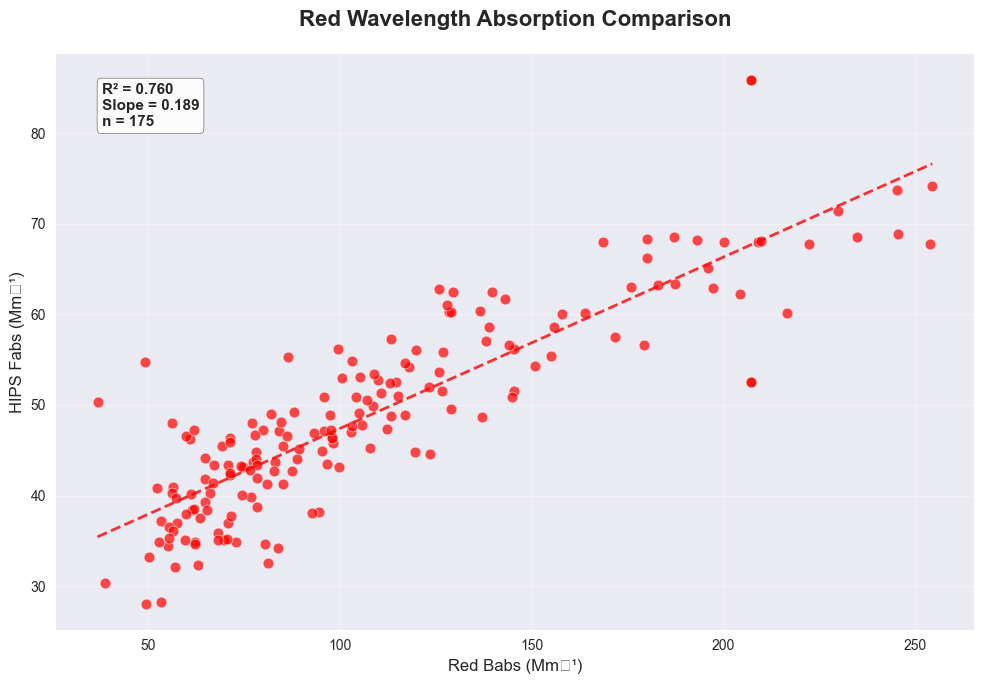

📊 Red Babs vs HIPS Fabs: R² = 0.760, Slope = 0.189


In [6]:
# Red wavelength Babs vs HIPS Fabs
if 'Red Babs' in matched_data.columns and 'HIPS_Fabs' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red Babs', 'HIPS_Fabs',
        'Red Wavelength Absorption Comparison',
        'Red Babs (Mm⁻¹)', 'HIPS Fabs (Mm⁻¹)', 
        color='red'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red Babs vs HIPS Fabs: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ Red Babs or HIPS_Fabs data not available")

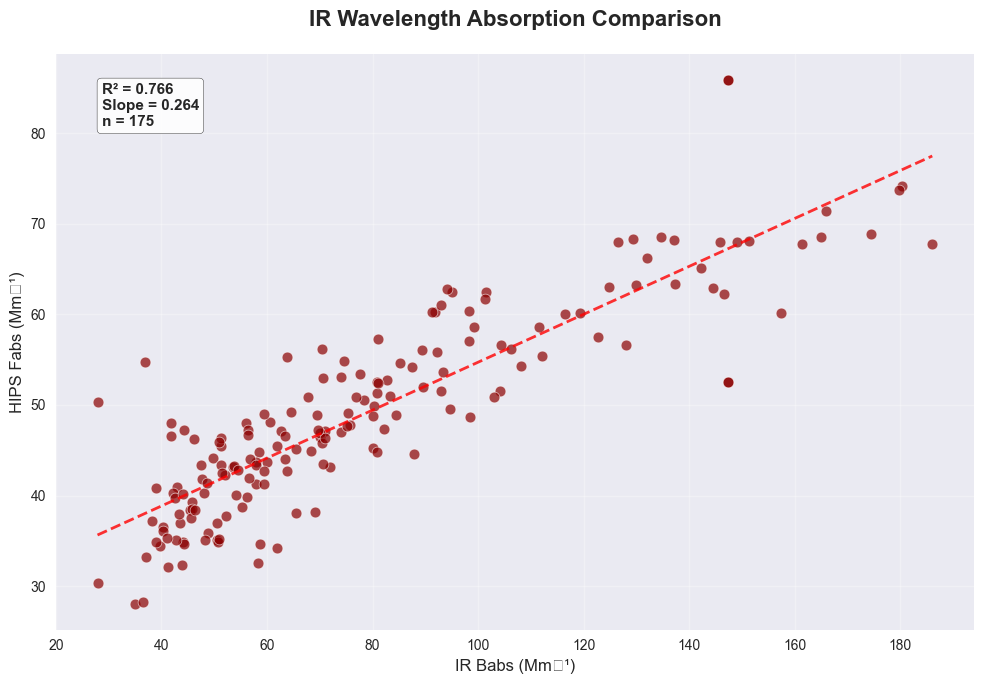

📊 IR Babs vs HIPS Fabs: R² = 0.766, Slope = 0.264


In [7]:
# IR wavelength Babs vs HIPS Fabs
if 'IR Babs' in matched_data.columns and 'HIPS_Fabs' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR Babs', 'HIPS_Fabs',
        'IR Wavelength Absorption Comparison',
        'IR Babs (Mm⁻¹)', 'HIPS Fabs (Mm⁻¹)', 
        color='darkred'
    )
    plt.show()
    
    if stats:
        print(f"📊 IR Babs vs HIPS Fabs: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ IR Babs or HIPS_Fabs data not available")

## 5. BCc vs FTIR EC Analysis

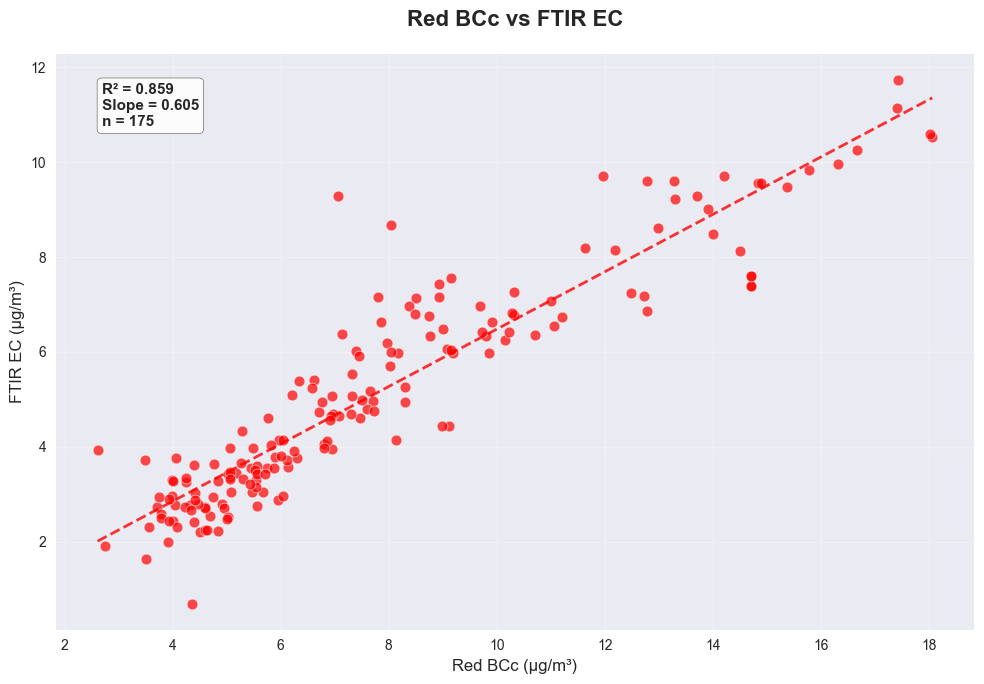

📊 Red BCc vs FTIR EC: R² = 0.859, Slope = 0.605


In [8]:
# Red BCc vs FTIR EC
if 'Red BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red BCc smoothed', 'EC_ftir',
        'Red BCc vs FTIR EC',
        'Red BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='red'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ Red BCc or FTIR EC data not available")

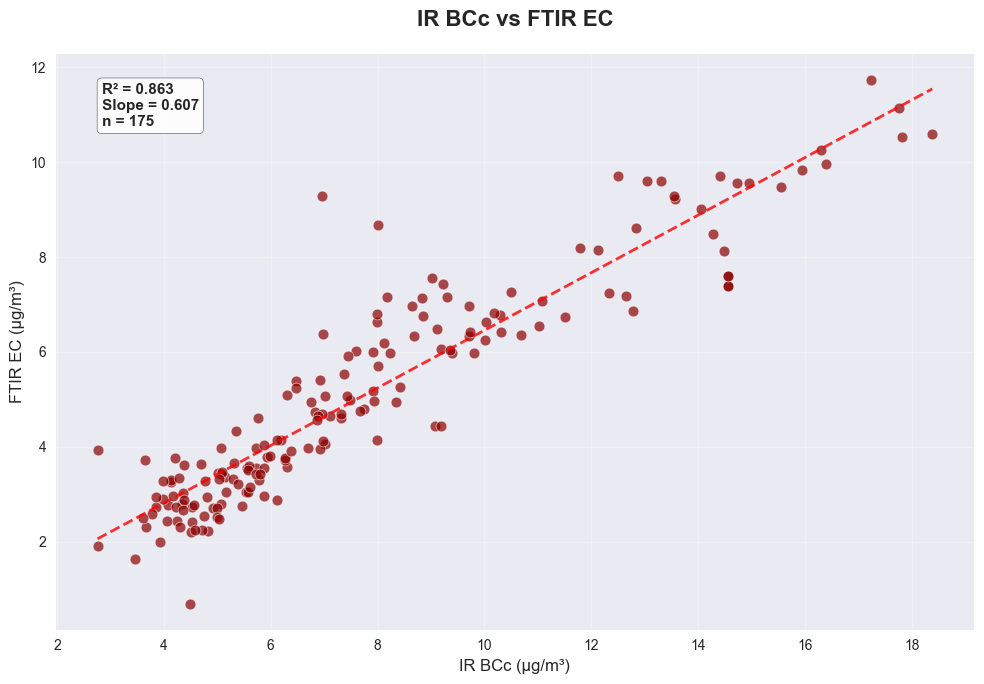

📊 IR BCc vs FTIR EC: R² = 0.863, Slope = 0.607


In [9]:
# IR BCc vs FTIR EC
if 'IR BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR BCc smoothed', 'EC_ftir',
        'IR BCc vs FTIR EC',
        'IR BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='darkred'
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ IR BCc or FTIR EC data not available")

## 6. BCc vs Iron Analysis

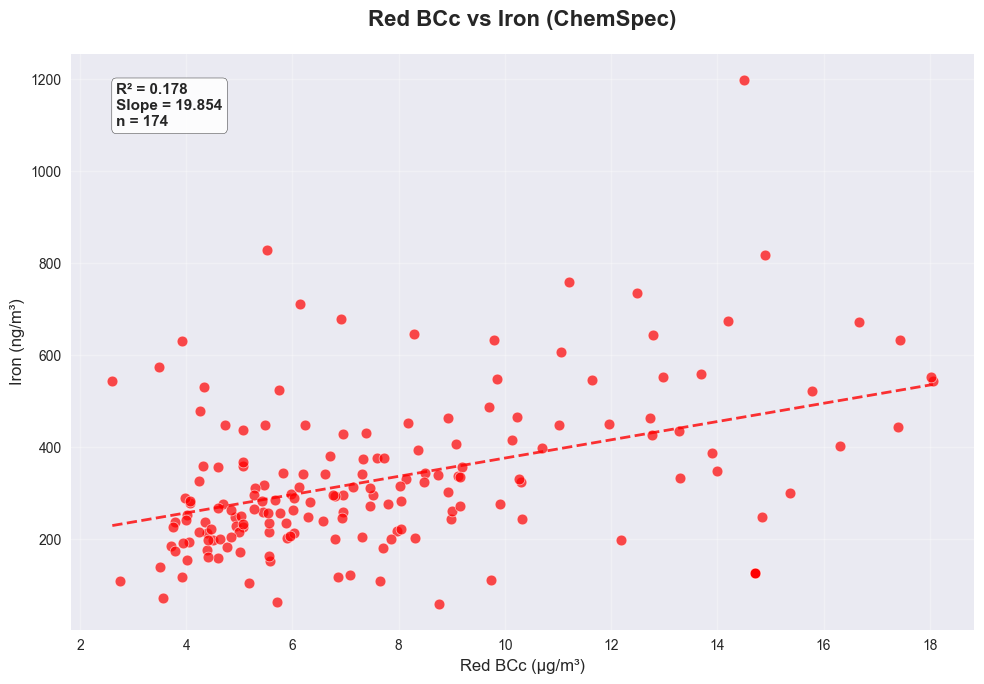

📊 Red BCc vs Iron: R² = 0.178, Slope = 19.854


In [10]:
# Red BCc vs Iron
if 'Red BCc smoothed' in matched_data.columns and 'Iron_ChemSpec' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red BCc smoothed', 'Iron_ChemSpec',
        'Red BCc vs Iron (ChemSpec)',
        'Red BCc (μg/m³)', 'Iron (ng/m³)', 
        color='red'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ Red BCc or Iron data not available")

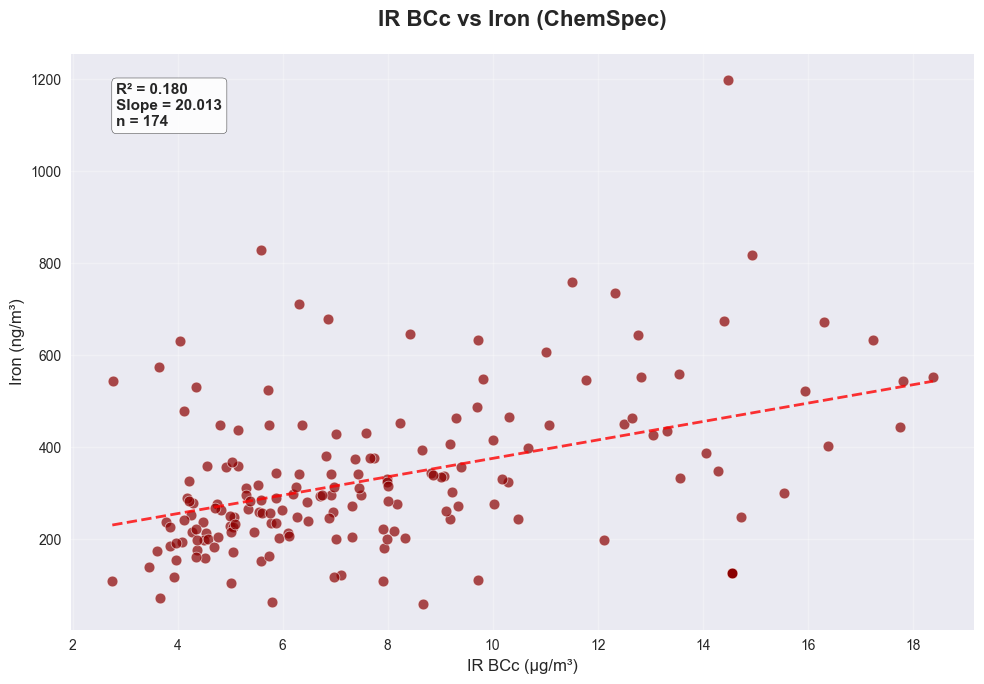

📊 IR BCc vs Iron: R² = 0.180, Slope = 20.013


In [11]:
# IR BCc vs Iron
if 'IR BCc smoothed' in matched_data.columns and 'Iron_ChemSpec' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR BCc smoothed', 'Iron_ChemSpec',
        'IR BCc vs Iron (ChemSpec)',
        'IR BCc (μg/m³)', 'Iron (ng/m³)', 
        color='darkred'
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ IR BCc or Iron data not available")

## 7. HIPS Fabs vs Iron Analysis

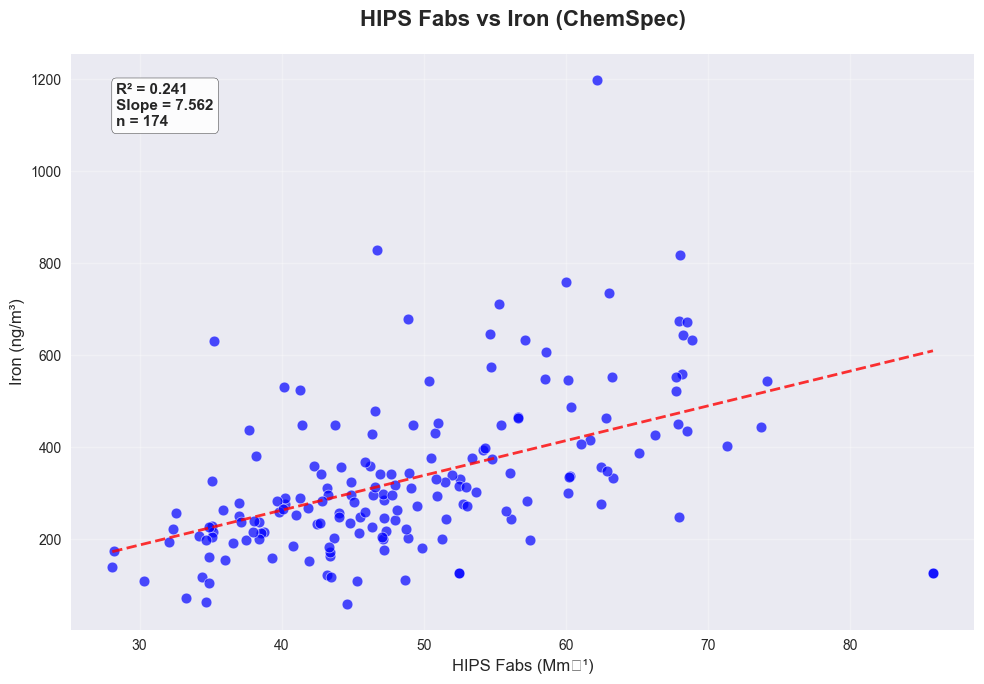

📊 HIPS Fabs vs Iron: R² = 0.241, Slope = 7.562


In [12]:
# HIPS Fabs vs Iron
if 'HIPS_Fabs' in matched_data.columns and 'Iron_ChemSpec' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'HIPS_Fabs', 'Iron_ChemSpec',
        'HIPS Fabs vs Iron (ChemSpec)',
        'HIPS Fabs (Mm⁻¹)', 'Iron (ng/m³)', 
        color='blue'
    )
    plt.show()
    
    if stats:
        print(f"📊 HIPS Fabs vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ HIPS Fabs or Iron data not available")

## 8. FTIR EC vs Iron Analysis

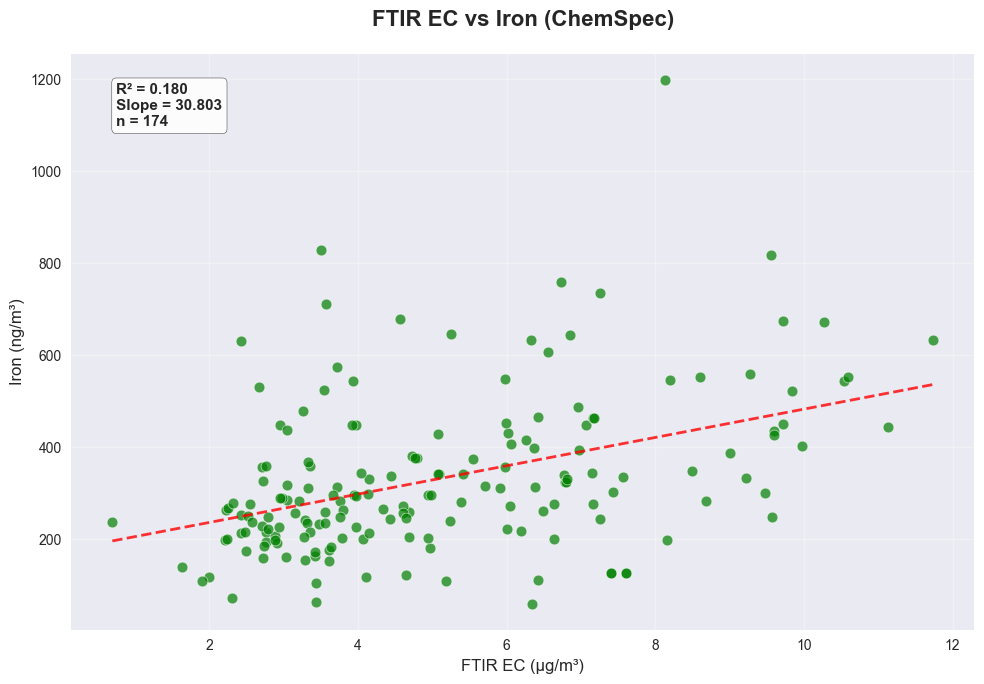

📊 FTIR EC vs Iron: R² = 0.180, Slope = 30.803


In [13]:
# FTIR EC vs Iron
if 'EC_ftir' in matched_data.columns and 'Iron_ChemSpec' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'EC_ftir', 'Iron_ChemSpec',
        'FTIR EC vs Iron (ChemSpec)',
        'FTIR EC (μg/m³)', 'Iron (ng/m³)', 
        color='green'
    )
    plt.show()
    
    if stats:
        print(f"📊 FTIR EC vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
else:
    print("❌ FTIR EC or Iron data not available")

## 9. Time Series Analysis

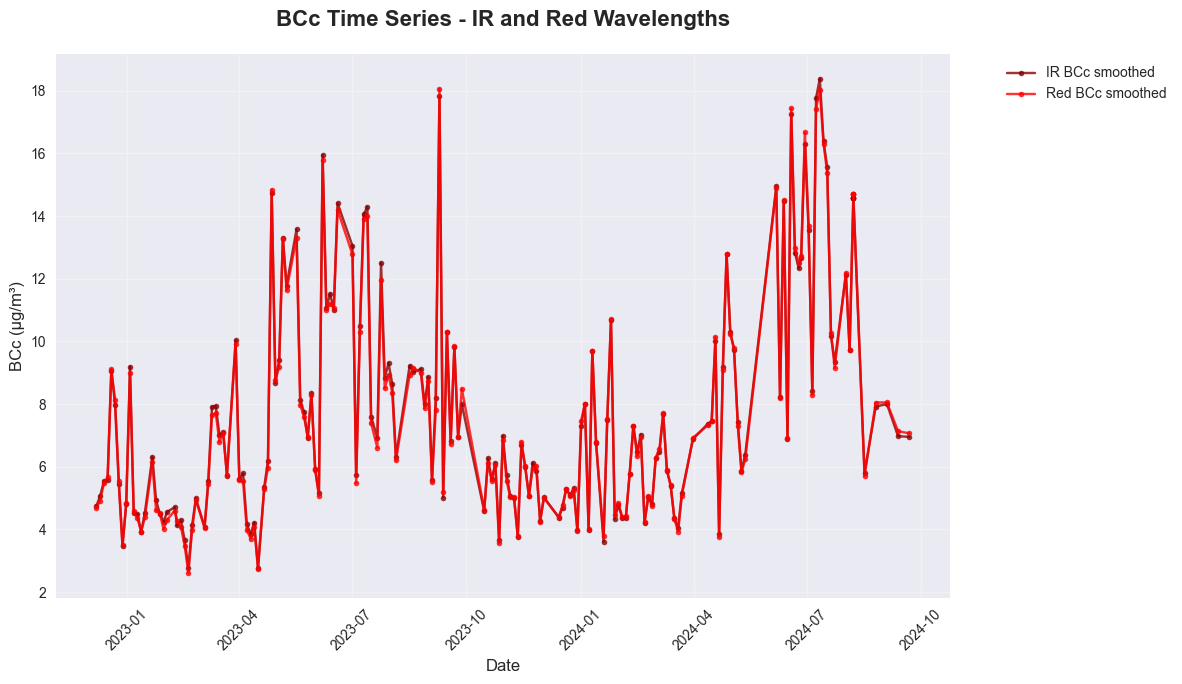

In [14]:
# Time series: BCc measurements
bc_columns = ['IR BCc smoothed', 'Red BCc smoothed']
fig, ax = create_time_series_plot(
    matched_data, bc_columns,
    'BCc Time Series - IR and Red Wavelengths',
    'BCc (μg/m³)',
    colors=['darkred', 'red']
)
plt.show()

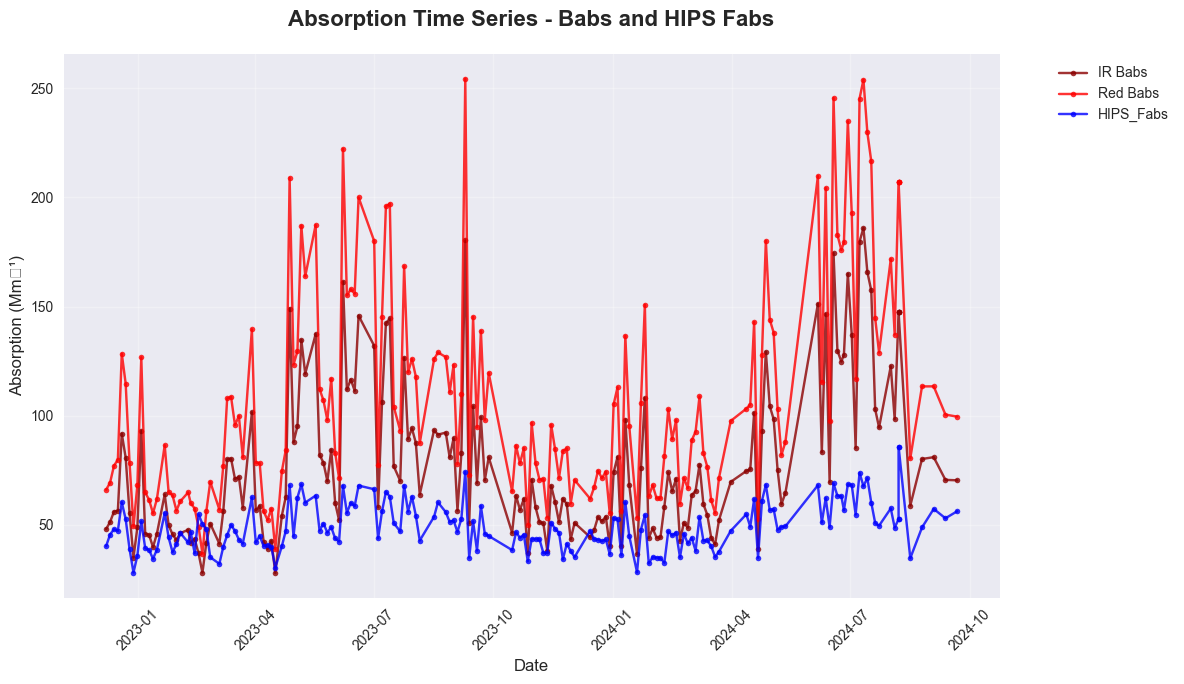

In [15]:
# Time series: Absorption measurements (Babs vs Fabs)
babs_fabs_columns = ['IR Babs', 'Red Babs', 'HIPS_Fabs']
available_cols = [col for col in babs_fabs_columns if col in matched_data.columns]

if available_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_cols,
        'Absorption Time Series - Babs and HIPS Fabs',
        'Absorption (Mm⁻¹)',
        colors=['darkred', 'red', 'blue']
    )
    plt.show()
else:
    print("❌ No absorption data available for time series")

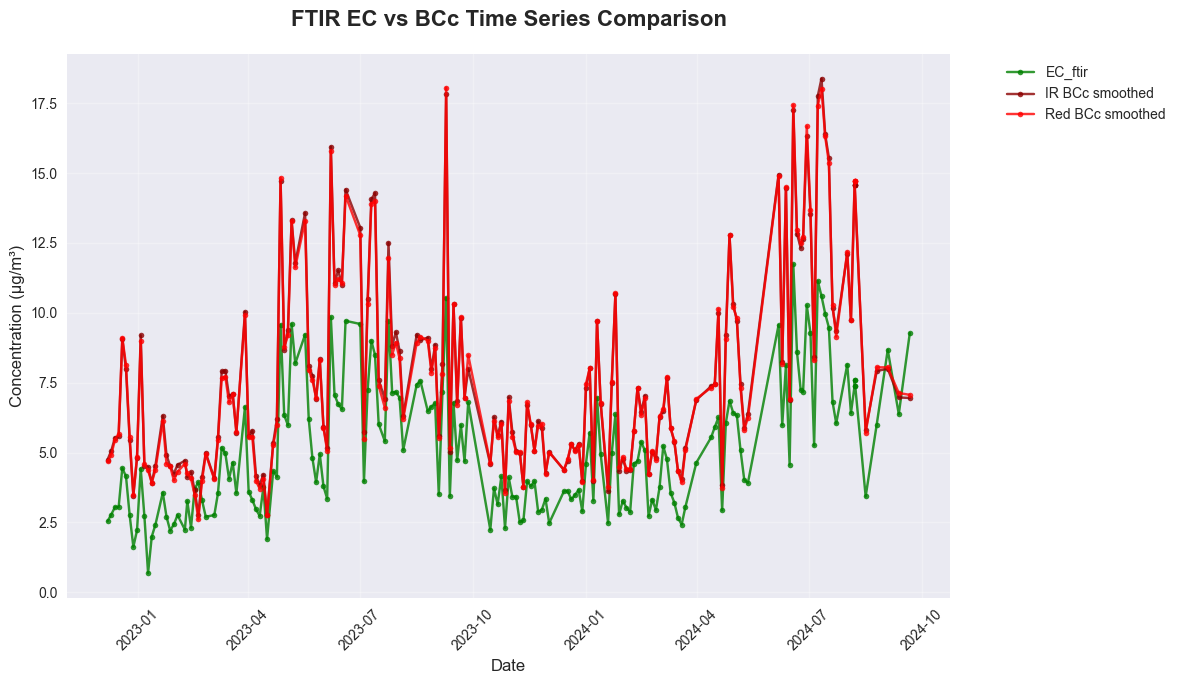

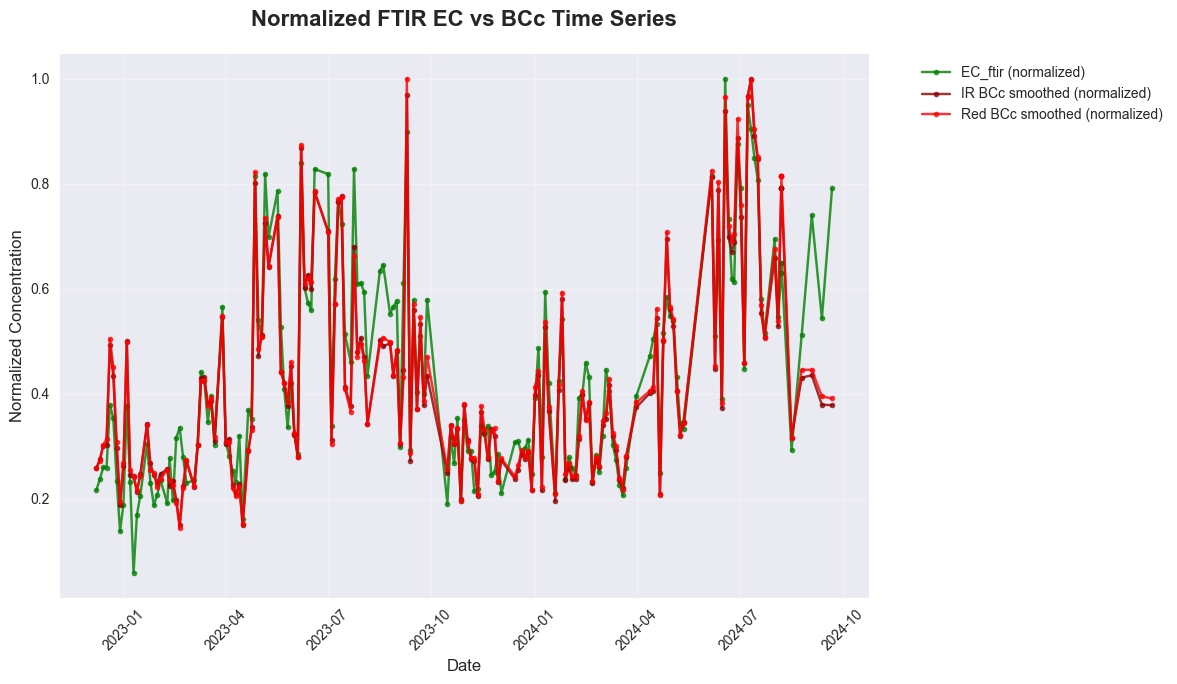

📊 Time series plots show both absolute and normalized comparisons
   Normalized plot allows visual comparison of temporal patterns


In [16]:
# Time series: FTIR EC vs BCc comparison
ec_bcc_columns = ['EC_ftir', 'IR BCc smoothed', 'Red BCc smoothed']
available_ec_bcc_cols = [col for col in ec_bcc_columns if col in matched_data.columns]

if available_ec_bcc_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_ec_bcc_cols,
        'FTIR EC vs BCc Time Series Comparison',
        'Concentration (μg/m³)',
        colors=['green', 'darkred', 'red']
    )
    plt.show()
    
    # Also create a normalized comparison for better visual comparison
    fig2, ax2 = plt.subplots(figsize=(12, 7))
    
    for i, col in enumerate(available_ec_bcc_cols):
        if col in matched_data.columns:
            mask = matched_data[col].notna()
            if mask.sum() > 0:
                # Normalize each parameter by its maximum value
                data_normalized = matched_data.loc[mask, col] / matched_data[col].max()
                colors = ['green', 'darkred', 'red']
                ax2.plot(matched_data.loc[mask, 'datetime_local'], data_normalized, 
                        'o-', label=f'{col} (normalized)', alpha=0.8, markersize=4, 
                        color=colors[i % len(colors)])
    
    ax2.set_title('Normalized FTIR EC vs BCc Time Series', fontsize=16, fontweight='bold', pad=20)
    ax2.set_ylabel('Normalized Concentration', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("📊 Time series plots show both absolute and normalized comparisons")
    print("   Normalized plot allows visual comparison of temporal patterns")
    
else:
    print("❌ No EC or BCc data available for time series")

## 9.5. Iron-Coded BCc vs FTIR EC Analysis

In [17]:
# Create Aethalometer vs FTIR-EC scatter plots (IR and Red wavelengths, Fe color-coding)
print("🎨 Creating BCc vs FTIR EC scatter plots with Iron color-coding...")

def create_iron_coded_scatter(data, x_col, y_col, iron_col, title, x_label, y_label):
    """
    Create scatter plot with Iron concentration color-coding.
    """
    fig, ax = plt.subplots(figsize=(11, 8))
    
    # Filter valid data for all three variables
    mask = data[[x_col, y_col, iron_col]].notna().all(axis=1)
    
    if mask.sum() < 3:
        ax.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        return fig, ax, {}
    
    x = data.loc[mask, x_col]
    y = data.loc[mask, y_col]
    iron = data.loc[mask, iron_col]
    
    # Create scatter plot with Iron color-coding
    scatter = ax.scatter(x, y, c=iron, cmap='plasma', alpha=0.7, s=60, 
                        edgecolors='white', linewidth=0.5)
    
    # Add colorbar for Iron
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Iron (ng/m³)', fontsize=12, fontweight='bold')
    
    # Regression line and statistics
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope, intercept = z
    
    # Plot regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red')
    
    # Calculate statistics
    corr = x.corr(y)
    r2 = corr**2
    n = len(x)
    
    # Iron statistics
    iron_mean = iron.mean()
    iron_std = iron.std()
    
    # Create legend with statistics
    stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}\nFe: {iron_mean:.1f} ± {iron_std:.1f} ng/m³'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=11, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax, {'r2': r2, 'slope': slope, 'n': n, 'corr': corr, 'iron_mean': iron_mean, 'iron_std': iron_std}

print("✅ Iron-coded scatter plot function defined")

🎨 Creating BCc vs FTIR EC scatter plots with Iron color-coding...
✅ Iron-coded scatter plot function defined


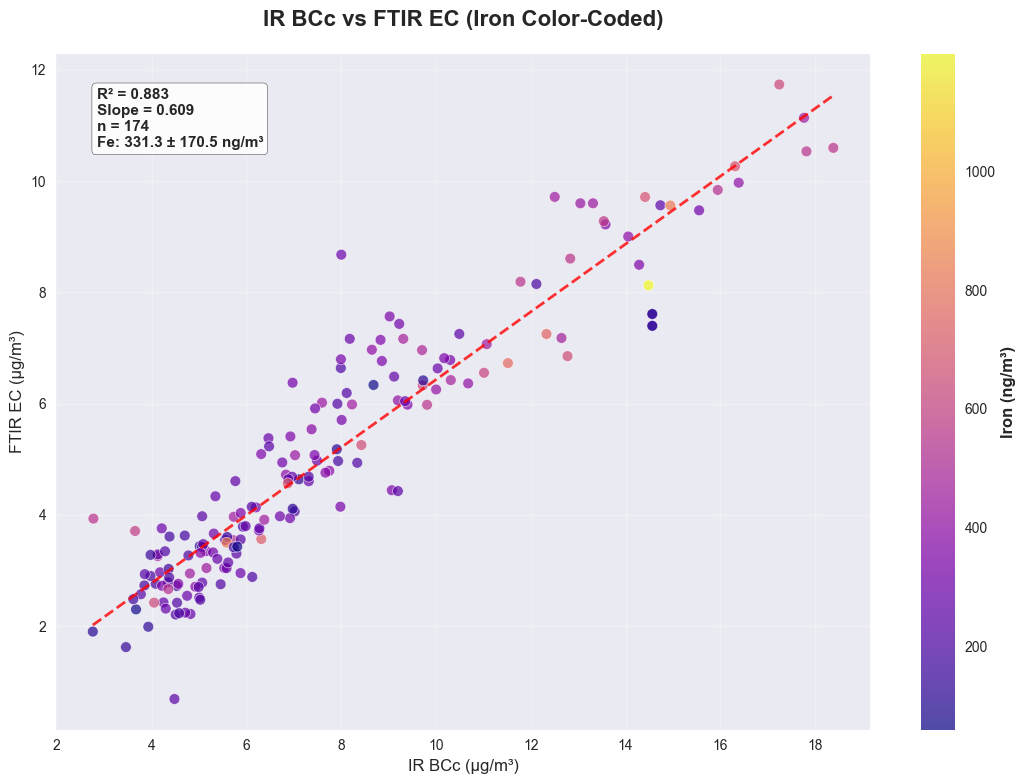

📊 IR BCc vs FTIR EC (Fe-coded): R² = 0.883, Slope = 0.609
🧲 Iron range: 331.3 ± 170.5 ng/m³


In [18]:
# IR BCc vs FTIR EC with Iron color-coding
if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec']):
    fig, ax, stats = create_iron_coded_scatter(
        matched_data, 'IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec',
        'IR BCc vs FTIR EC (Iron Color-Coded)',
        'IR BCc (μg/m³)', 'FTIR EC (μg/m³)'
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs FTIR EC (Fe-coded): R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
        print(f"🧲 Iron range: {stats['iron_mean']:.1f} ± {stats['iron_std']:.1f} ng/m³")
else:
    print("❌ IR BCc, FTIR EC, or Iron data not available")

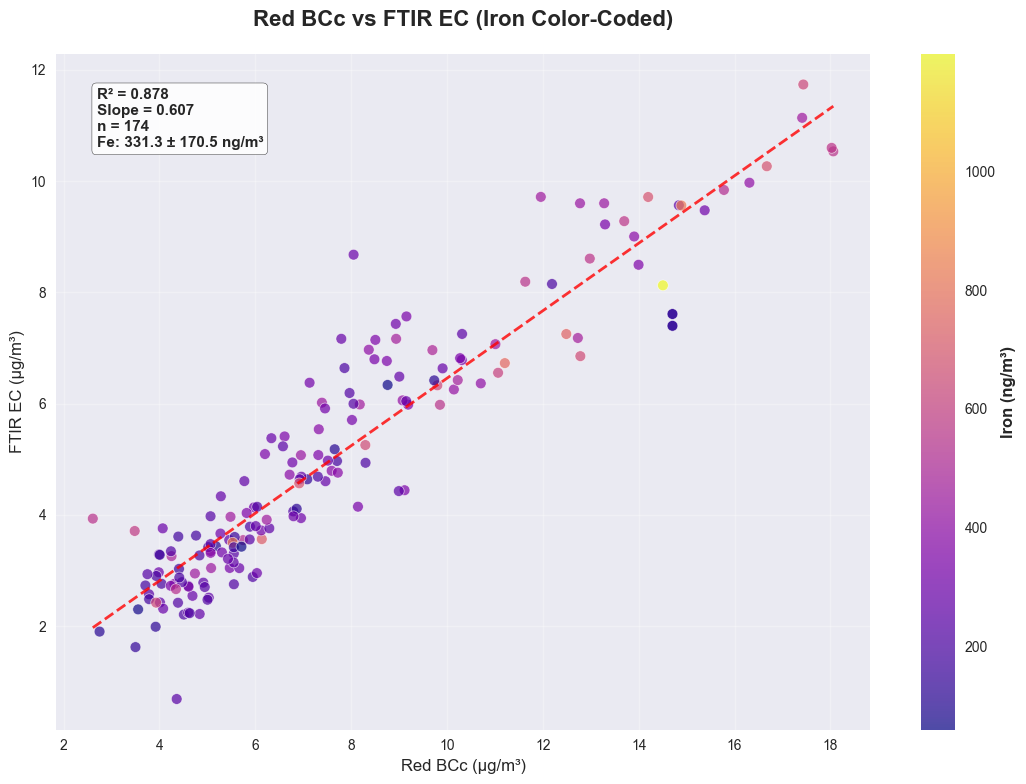

📊 Red BCc vs FTIR EC (Fe-coded): R² = 0.878, Slope = 0.607
🧲 Iron range: 331.3 ± 170.5 ng/m³


In [19]:
# Red BCc vs FTIR EC with Iron color-coding  
if all(col in matched_data.columns for col in ['Red BCc smoothed', 'EC_ftir', 'Iron_ChemSpec']):
    fig, ax, stats = create_iron_coded_scatter(
        matched_data, 'Red BCc smoothed', 'EC_ftir', 'Iron_ChemSpec',
        'Red BCc vs FTIR EC (Iron Color-Coded)', 
        'Red BCc (μg/m³)', 'FTIR EC (μg/m³)'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs FTIR EC (Fe-coded): R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}")
        print(f"🧲 Iron range: {stats['iron_mean']:.1f} ± {stats['iron_std']:.1f} ng/m³")
else:
    print("❌ Red BCc, FTIR EC, or Iron data not available")

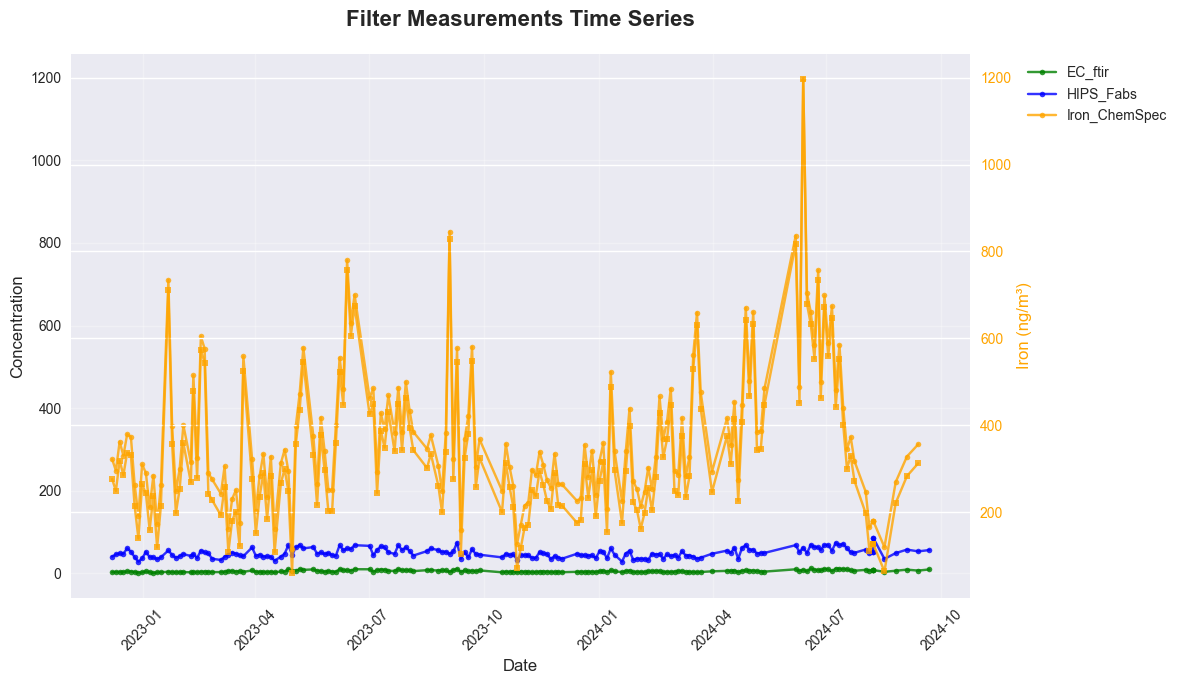

In [20]:
# Time series: Filter measurements
filter_columns = ['EC_ftir', 'HIPS_Fabs', 'Iron_ChemSpec']
available_filter_cols = [col for col in filter_columns if col in matched_data.columns]

if available_filter_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_filter_cols,
        'Filter Measurements Time Series',
        'Concentration',
        colors=['green', 'blue', 'orange']
    )
    
    # Add secondary y-axis for Iron (different scale)
    if 'Iron_ChemSpec' in available_filter_cols:
        ax2 = ax.twinx()
        mask = matched_data['Iron_ChemSpec'].notna()
        if mask.sum() > 0:
            ax2.plot(matched_data.loc[mask, 'datetime_local'], matched_data.loc[mask, 'Iron_ChemSpec'], 
                    's-', label='Iron_ChemSpec', alpha=0.8, markersize=4, color='orange')
            ax2.set_ylabel('Iron (ng/m³)', fontsize=12, color='orange')
            ax2.tick_params(axis='y', labelcolor='orange')
    
    plt.show()
else:
    print("❌ No filter data available for time series")

## 9.6. Seasonal MAC Analysis

Calculate Mass Absorption Cross-section (MAC = HIPS Fabs / FTIR EC) by Ethiopian seasons.

In [21]:
# Calculate seasonal MAC values (HIPS Fabs / FTIR EC)
print("🌍 Calculating seasonal MAC values for Ethiopian seasons...")

# Ethiopian season mapping
def map_ethiopian_seasons(month):
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:
        return 'Kiremt Rainy Season'

if 'HIPS_Fabs' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    # Filter valid data
    mac_mask = matched_data[['HIPS_Fabs', 'EC_ftir']].notna().all(axis=1)
    
    if mac_mask.sum() > 0:
        # Calculate MAC = HIPS Fabs / FTIR EC
        matched_data.loc[mac_mask, 'MAC'] = matched_data.loc[mac_mask, 'HIPS_Fabs'] / matched_data.loc[mac_mask, 'EC_ftir']
        
        # Extract month and map to Ethiopian seasons
        matched_data['month'] = matched_data['datetime_local'].dt.month
        matched_data['Ethiopian_Season'] = matched_data['month'].apply(map_ethiopian_seasons)
        
        print(f"📊 MAC calculated for {mac_mask.sum()} samples")
        print(f"📅 Date range: {matched_data.loc[mac_mask, 'match_date'].min()} to {matched_data.loc[mac_mask, 'match_date'].max()}")
        
        # Seasonal MAC statistics
        print("🌦️  Seasonal MAC Statistics:")
        seasonal_stats = matched_data.loc[mac_mask].groupby('Ethiopian_Season')['MAC'].agg(['count', 'mean', 'std', 'min', 'max'])
        
        for season in seasonal_stats.index:
            stats = seasonal_stats.loc[season]
            print(f"   {season}:")
            print(f"     Count: {stats['count']} samples")
            print(f"     MAC: {stats['mean']:.2f} ± {stats['std']:.2f} m²/g")
            print(f"     Range: {stats['min']:.2f} - {stats['max']:.2f} m²/g")
        
        print("✅ MAC values calculated as HIPS_Fabs / EC_ftir")
    else:
        print("❌ No valid HIPS Fabs and EC data for MAC calculation")
else:
    print("❌ HIPS Fabs or EC_ftir data not available")

🌍 Calculating seasonal MAC values for Ethiopian seasons...
📊 MAC calculated for 175 samples
📅 Date range: 2022-12-07 to 2024-09-21
🌦️  Seasonal MAC Statistics:
   Belg Rainy Season:
     Count: 46.0 samples
     MAC: 10.65 ± 2.28 m²/g
     Range: 6.87 - 15.93 m²/g
   Dry Season:
     Count: 68.0 samples
     MAC: 13.76 ± 5.72 m²/g
     Range: 7.07 - 55.41 m²/g
   Kiremt Rainy Season:
     Count: 61.0 samples
     MAC: 8.21 ± 1.63 m²/g
     Range: 5.87 - 13.34 m²/g
✅ MAC values calculated as HIPS_Fabs / EC_ftir


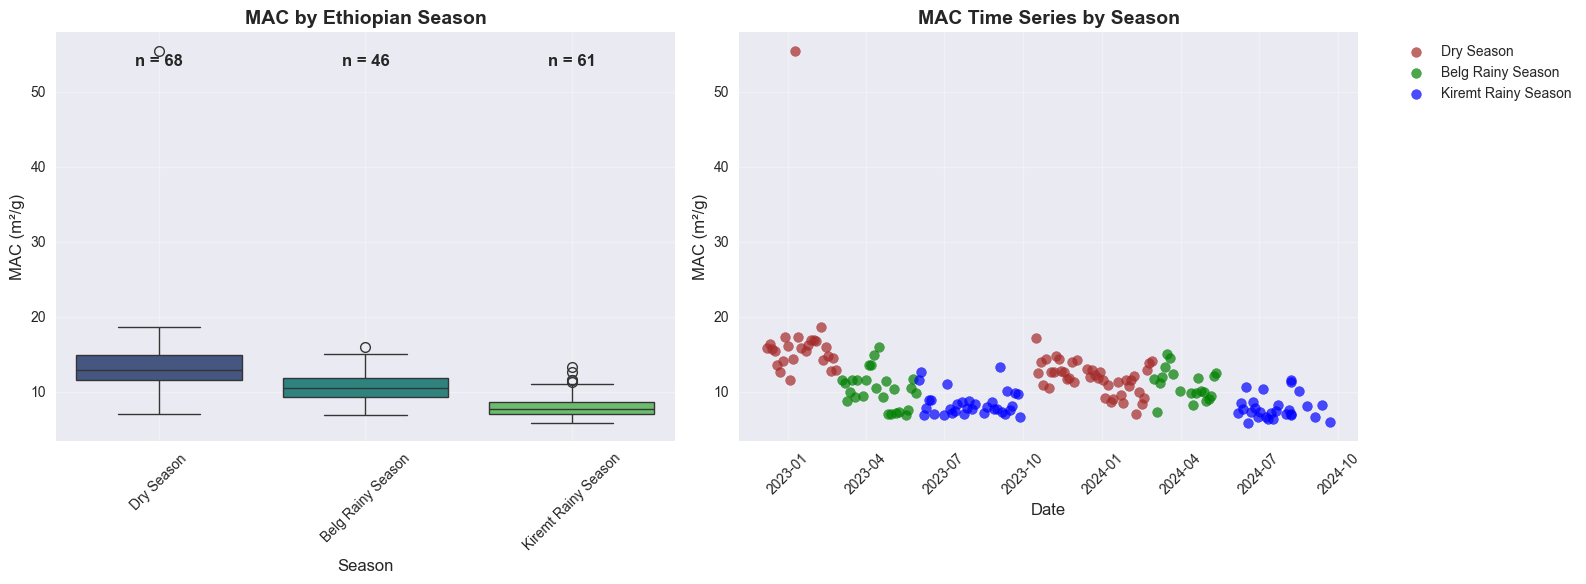

📈 Seasonal MAC Comparison:
   Overall MAC: 11.01 ± 4.54 m²/g (n = 175)
   Season Ratios (relative to Dry Season):
     Belg Rainy Season: 0.77x
     Dry Season: 1.00x
     Kiremt Rainy Season: 0.60x
✅ Seasonal MAC analysis complete!


In [22]:
# Create seasonal MAC visualizations
if 'MAC' in matched_data.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    valid_mac = matched_data[matched_data['MAC'].notna()]
    
    if len(valid_mac) > 0:
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: MAC box plot by season
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac['Ethiopian_Season'].values]
        
        if len(available_seasons) > 0:
            sns.boxplot(data=valid_mac, x='Ethiopian_Season', y='MAC', 
                       order=available_seasons, ax=ax1, palette='viridis')
            ax1.set_title('MAC by Ethiopian Season', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Season', fontsize=12)
            ax1.set_ylabel('MAC (m²/g)', fontsize=12)
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(True, alpha=0.3)
            
            # Add sample sizes to plot
            for i, season in enumerate(available_seasons):
                count = len(valid_mac[valid_mac['Ethiopian_Season'] == season])
                ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                        ha='center', va='top', fontweight='bold')
        
        # Plot 2: MAC time series with season coloring
        season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
        
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season]
            if len(season_data) > 0:
                ax2.scatter(season_data['datetime_local'], season_data['MAC'], 
                           label=season, alpha=0.7, s=50, 
                           color=season_colors.get(season, 'gray'))
        
        ax2.set_title('MAC Time Series by Season', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('MAC (m²/g)', fontsize=12)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("📈 Seasonal MAC Comparison:")
        
        # ANOVA-like comparison
        season_groups = []
        for season in available_seasons:
            season_mac = valid_mac[valid_mac['Ethiopian_Season'] == season]['MAC'].values
            season_groups.append(season_mac)
            
        # Calculate overall statistics
        overall_mac = valid_mac['MAC']
        print(f"   Overall MAC: {overall_mac.mean():.2f} ± {overall_mac.std():.2f} m²/g (n = {len(overall_mac)})")
        
        # Season-to-season ratios
        season_means = valid_mac.groupby('Ethiopian_Season')['MAC'].mean()
        print("   Season Ratios (relative to Dry Season):")
        if 'Dry Season' in season_means.index:
            dry_mean = season_means['Dry Season']
            for season in season_means.index:
                ratio = season_means[season] / dry_mean
                print(f"     {season}: {ratio:.2f}x")
        
        print("✅ Seasonal MAC analysis complete!")
    else:
        print("❌ No valid MAC data for visualization")
else:
    print("❌ MAC not calculated - skipping visualization")

## 10. Summary Statistics

In [23]:
# Generate comprehensive summary
print("📊 ETAD Comprehensive Absorption Analysis Summary")
print("=" * 70)

# Basic info
print(f"📅 Analysis period: {matched_data['match_date'].min()} to {matched_data['match_date'].max()}")
print(f"📊 Total matched records: {len(matched_data)}")

# Key correlations summary
print(f"\n🎯 Key Correlation Results:")

# List of key comparisons
key_comparisons = [
    ('Red Babs', 'HIPS_Fabs', 'Red Babs vs HIPS Fabs'),
    ('IR Babs', 'HIPS_Fabs', 'IR Babs vs HIPS Fabs'),
    ('Red BCc smoothed', 'EC_ftir', 'Red BCc vs FTIR EC'),
    ('IR BCc smoothed', 'EC_ftir', 'IR BCc vs FTIR EC'),
    ('Red BCc smoothed', 'Iron_ChemSpec', 'Red BCc vs Iron'),
    ('IR BCc smoothed', 'Iron_ChemSpec', 'IR BCc vs Iron'),
    ('HIPS_Fabs', 'Iron_ChemSpec', 'HIPS Fabs vs Iron'),
    ('EC_ftir', 'Iron_ChemSpec', 'FTIR EC vs Iron')
]

for col1, col2, label in key_comparisons:
    if col1 in matched_data.columns and col2 in matched_data.columns:
        mask = matched_data[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 2:
            corr = matched_data.loc[mask, col1].corr(matched_data.loc[mask, col2])
            r2 = corr**2
            
            # Calculate slope
            x = matched_data.loc[mask, col1]
            y = matched_data.loc[mask, col2]
            slope = np.polyfit(x, y, 1)[0]
            
            n = mask.sum()
            print(f"   {label:<25}: R² = {r2:6.3f}, Slope = {slope:8.3f} (n = {n})")
        else:
            print(f"   {label:<25}: Insufficient data")
    else:
        print(f"   {label:<25}: Data not available")

print(f"\n📈 Data Completeness:")
for col in matched_data.columns:
    if col not in ['match_date', 'datetime_local']:
        if matched_data[col].dtype in ['float64', 'int64']:
            count = matched_data[col].notna().sum()
            percentage = (count / len(matched_data)) * 100
            print(f"   {col:<25}: {count:3d}/{len(matched_data)} ({percentage:5.1f}%)")

print(f"\n✅ Comprehensive analysis complete!")
print(f"📁 All plots generated individually with consistent formatting")
print(f"📊 R² values, slopes, and sample sizes shown in legends")
print(f"🔬 Proper Babs calculations using σATN cross-sections")

📊 ETAD Comprehensive Absorption Analysis Summary
📅 Analysis period: 2022-12-07 to 2024-09-21
📊 Total matched records: 175

🎯 Key Correlation Results:
   Red Babs vs HIPS Fabs    : R² =  0.760, Slope =    0.189 (n = 175)
   IR Babs vs HIPS Fabs     : R² =  0.766, Slope =    0.264 (n = 175)
   Red BCc vs FTIR EC       : R² =  0.859, Slope =    0.605 (n = 175)
   IR BCc vs FTIR EC        : R² =  0.863, Slope =    0.607 (n = 175)
   Red BCc vs Iron          : R² =  0.178, Slope =   19.854 (n = 174)
   IR BCc vs Iron           : R² =  0.180, Slope =   20.013 (n = 174)
   HIPS Fabs vs Iron        : R² =  0.241, Slope =    7.562 (n = 174)
   FTIR EC vs Iron          : R² =  0.180, Slope =   30.803 (n = 174)

📈 Data Completeness:
   IR BCc smoothed          : 175/175 (100.0%)
   Red BCc smoothed         : 175/175 (100.0%)
   Green BCc smoothed       : 175/175 (100.0%)
   Blue BCc smoothed        : 175/175 (100.0%)
   UV BCc smoothed          : 175/175 (100.0%)
   index                    : 175

## 10.5. MAC Outlier Analysis and Improved Seasonal Visualization

In [24]:
# Identify and investigate MAC outliers
print("🔍 Identifying MAC outliers...")

if 'MAC' in matched_data.columns:
    valid_mac = matched_data[matched_data['MAC'].notna()].copy()
    
    if len(valid_mac) > 0:
        # Calculate overall statistics
        mac_mean = valid_mac['MAC'].mean()
        mac_std = valid_mac['MAC'].std()
        mac_median = valid_mac['MAC'].median()
        
        print(f"📊 Overall MAC Statistics:")
        print(f"   Mean: {mac_mean:.2f} m²/g")
        print(f"   Median: {mac_median:.2f} m²/g") 
        print(f"   Std Dev: {mac_std:.2f} m²/g")
        print(f"   Range: {valid_mac['MAC'].min():.2f} - {valid_mac['MAC'].max():.2f} m²/g")
        
        # Define outlier threshold (e.g., 3 standard deviations)
        outlier_threshold = mac_mean + 3 * mac_std
        print(f"   Outlier threshold (mean + 3σ): {outlier_threshold:.2f} m²/g")
        
        # Identify outliers
        outliers = valid_mac[valid_mac['MAC'] > outlier_threshold]
        
        if len(outliers) > 0:
            print(f"\n🚨 Found {len(outliers)} outlier(s):")
            for idx, row in outliers.iterrows():
                print(f"   Date: {row['match_date']}, MAC: {row['MAC']:.2f} m²/g, Season: {row['Ethiopian_Season']}")
                print(f"   HIPS_Fabs: {row['HIPS_Fabs']:.2f} Mm⁻¹, EC_ftir: {row['EC_ftir']:.3f} μg/m³")
                if 'Iron_ChemSpec' in row and pd.notna(row['Iron_ChemSpec']):
                    print(f"   Iron: {row['Iron_ChemSpec']:.1f} ng/m³")
                print()
        else:
            print("\n✅ No extreme outliers found using 3σ threshold")
            
        # Alternative: Use IQR method for outlier detection
        Q1 = valid_mac['MAC'].quantile(0.25)
        Q3 = valid_mac['MAC'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f"📈 IQR-based outlier detection:")
        print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"   Outlier bounds: {lower_bound:.2f} - {upper_bound:.2f} m²/g")
        
        iqr_outliers = valid_mac[(valid_mac['MAC'] < lower_bound) | (valid_mac['MAC'] > upper_bound)]
        
        if len(iqr_outliers) > 0:
            print(f"\n🚨 IQR outliers ({len(iqr_outliers)} found):")
            for idx, row in iqr_outliers.iterrows():
                print(f"   Date: {row['match_date']}, MAC: {row['MAC']:.2f} m²/g, Season: {row['Ethiopian_Season']}")
        
        # Create dataset without outliers (using IQR method)
        valid_mac_no_outliers = valid_mac[(valid_mac['MAC'] >= lower_bound) & (valid_mac['MAC'] <= upper_bound)].copy()
        
        print(f"\n📊 Data summary:")
        print(f"   Original data points: {len(valid_mac)}")
        print(f"   After outlier removal: {len(valid_mac_no_outliers)}")
        print(f"   Outliers removed: {len(valid_mac) - len(valid_mac_no_outliers)}")
        
    else:
        print("❌ No valid MAC data available")
else:
    print("❌ MAC column not found")

🔍 Identifying MAC outliers...
📊 Overall MAC Statistics:
   Mean: 11.01 m²/g
   Median: 10.56 m²/g
   Std Dev: 4.54 m²/g
   Range: 5.87 - 55.41 m²/g
   Outlier threshold (mean + 3σ): 24.62 m²/g

🚨 Found 1 outlier(s):
   Date: 2023-01-09, MAC: 55.41 m²/g, Season: Dry Season
   HIPS_Fabs: 38.40 Mm⁻¹, EC_ftir: 0.693 μg/m³
   Iron: 236.5 ng/m³

📈 IQR-based outlier detection:
   Q1: 8.02, Q3: 12.80, IQR: 4.78
   Outlier bounds: 0.85 - 19.97 m²/g

🚨 IQR outliers (1 found):
   Date: 2023-01-09, MAC: 55.41 m²/g, Season: Dry Season

📊 Data summary:
   Original data points: 175
   After outlier removal: 174
   Outliers removed: 1


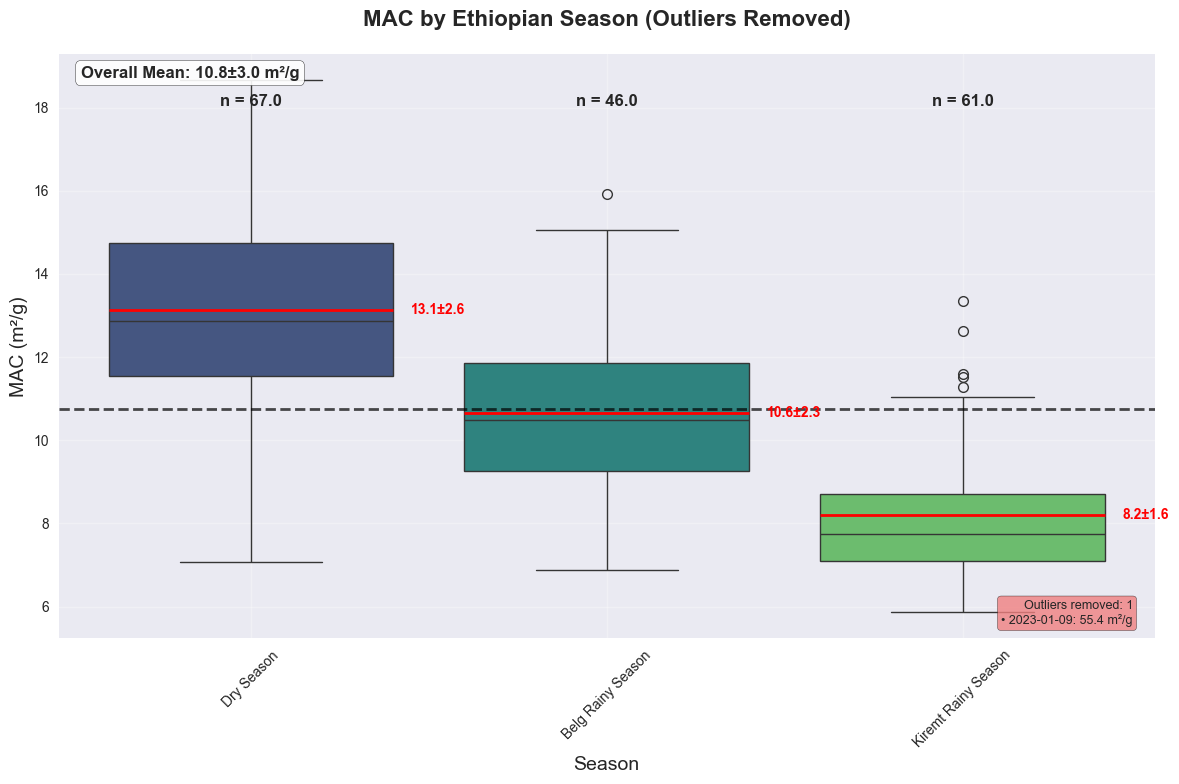

📊 Seasonal MAC Statistics (outliers removed):
   Dry Season:
     Count: 67.0 samples
     Mean: 13.14 ± 2.55 m²/g
   Belg Rainy Season:
     Count: 46.0 samples
     Mean: 10.65 ± 2.28 m²/g
   Kiremt Rainy Season:
     Count: 61.0 samples
     Mean: 8.21 ± 1.63 m²/g
   Overall (outliers removed): 10.75 ± 3.04 m²/g


In [25]:
# Create improved seasonal MAC visualizations with outlier investigation
if 'MAC' in matched_data.columns and len(valid_mac_no_outliers) > 0:
    
    # Create separate plots for each season
    seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    available_seasons = [s for s in seasons_order if s in valid_mac_no_outliers['Ethiopian_Season'].values]
    season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
    
    # First, create the box plot with averages
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Box plot without outliers
    sns.boxplot(data=valid_mac_no_outliers, x='Ethiopian_Season', y='MAC', 
               order=available_seasons, ax=ax, palette='viridis')
    
    ax.set_title('MAC by Ethiopian Season (Outliers Removed)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Season', fontsize=14)
    ax.set_ylabel('MAC (m²/g)', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Calculate and display statistics for each season
    season_stats = valid_mac_no_outliers.groupby('Ethiopian_Season')['MAC'].agg(['count', 'mean', 'std'])
    overall_mean = valid_mac_no_outliers['MAC'].mean()
    overall_std = valid_mac_no_outliers['MAC'].std()
    
    # Add sample sizes and means to plot
    for i, season in enumerate(available_seasons):
        stats = season_stats.loc[season]
        count = stats['count']
        mean_val = stats['mean']
        std_val = stats['std']
        
        # Add sample size
        ax.text(i, ax.get_ylim()[1] * 0.95, f'n = {count}', 
                ha='center', va='top', fontweight='bold', fontsize=12)
        
        # Add mean line and label
        ax.hlines(mean_val, i-0.4, i+0.4, colors='red', linestyles='solid', linewidth=2)
        ax.text(i+0.45, mean_val, f'{mean_val:.1f}±{std_val:.1f}', 
                va='center', fontweight='bold', fontsize=10, color='red')
    
    # Add overall mean line
    ax.axhline(overall_mean, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(0.02, 0.98, f'Overall Mean: {overall_mean:.1f}±{overall_std:.1f} m²/g', 
            transform=ax.transAxes, va='top', fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Add outlier information
    if len(iqr_outliers) > 0:
        outlier_info = f"Outliers removed: {len(iqr_outliers)}\n"
        for _, row in iqr_outliers.iterrows():
            outlier_info += f"• {row['match_date']}: {row['MAC']:.1f} m²/g\n"
        ax.text(0.98, 0.02, outlier_info.strip(), transform=ax.transAxes, 
                ha='right', va='bottom', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Seasonal MAC Statistics (outliers removed):")
    for season in available_seasons:
        stats = season_stats.loc[season]
        print(f"   {season}:")
        print(f"     Count: {stats['count']} samples")
        print(f"     Mean: {stats['mean']:.2f} ± {stats['std']:.2f} m²/g")
        
    print(f"   Overall (outliers removed): {overall_mean:.2f} ± {overall_std:.2f} m²/g")

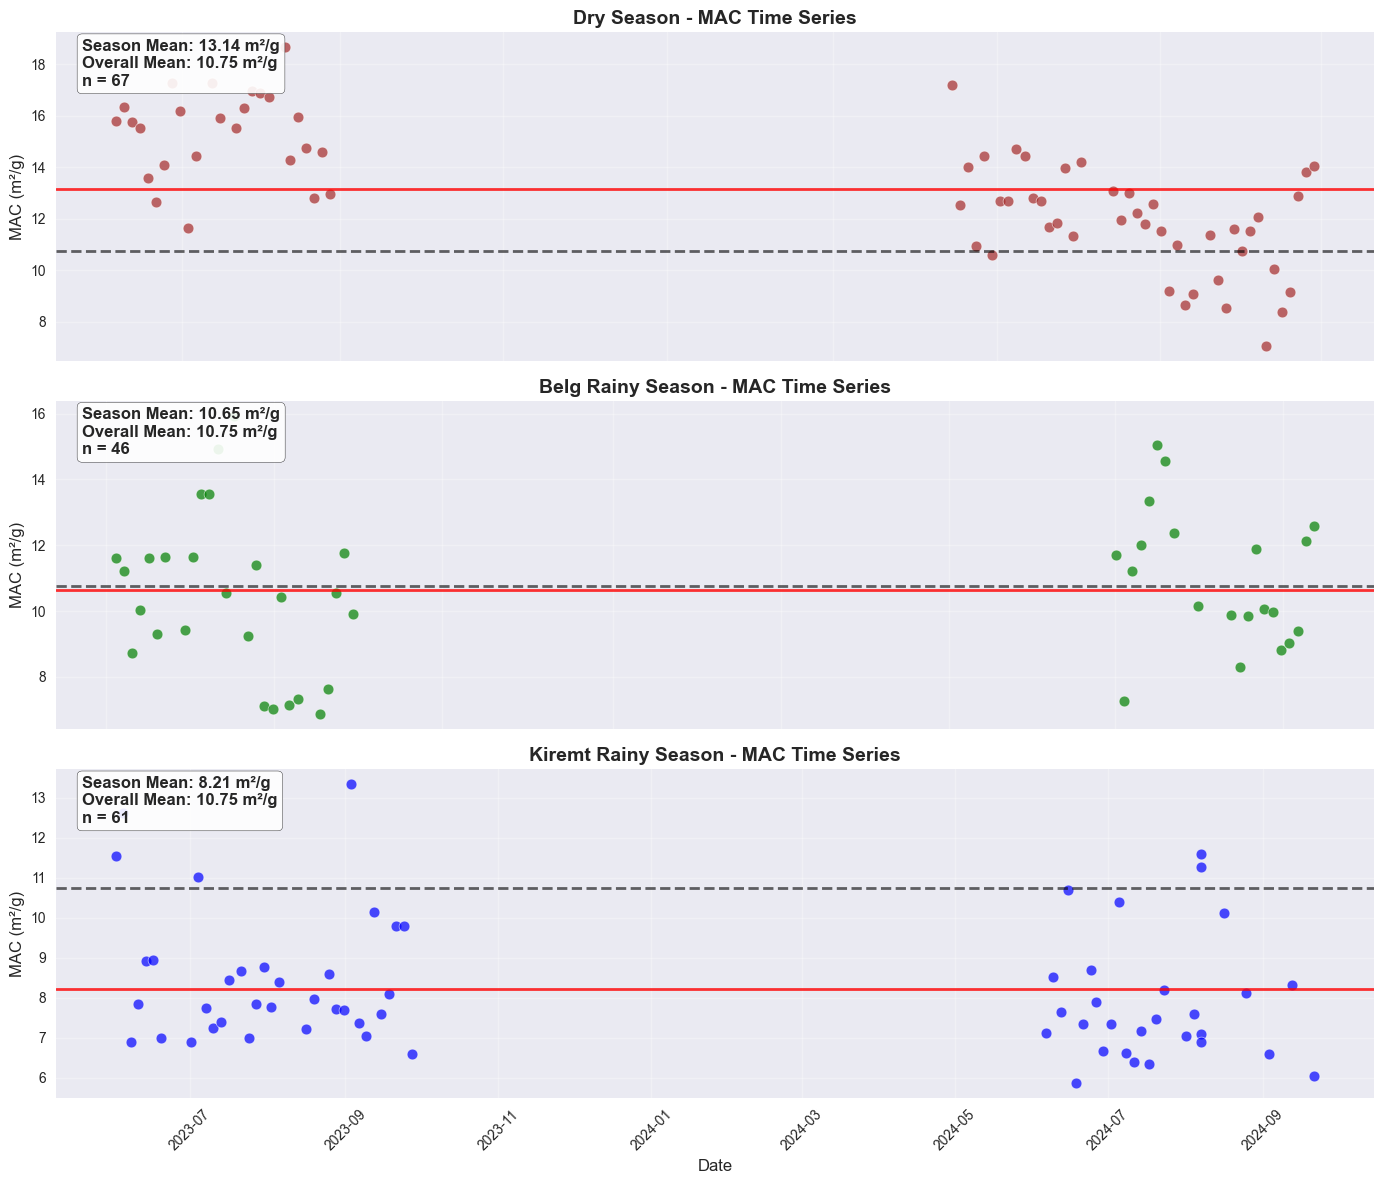

In [26]:
# Create separate time series plots for each season
if 'MAC' in matched_data.columns and len(valid_mac_no_outliers) > 0:
    
    # Calculate season means for reference lines
    season_means = valid_mac_no_outliers.groupby('Ethiopian_Season')['MAC'].mean()
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    for i, season in enumerate(available_seasons):
        ax = axes[i]
        
        # Data for this season (without outliers)
        season_data = valid_mac_no_outliers[valid_mac_no_outliers['Ethiopian_Season'] == season]
        
        if len(season_data) > 0:
            # Scatter plot
            ax.scatter(season_data['datetime_local'], season_data['MAC'], 
                      alpha=0.7, s=60, color=season_colors.get(season, 'gray'),
                      edgecolors='white', linewidth=0.5)
            
            # Add season mean line
            season_mean = season_means[season]
            ax.axhline(season_mean, color='red', linestyle='-', linewidth=2, alpha=0.8)
            
            # Add overall mean line for comparison
            ax.axhline(overall_mean, color='black', linestyle='--', linewidth=2, alpha=0.6)
            
            ax.set_title(f'{season} - MAC Time Series', fontsize=14, fontweight='bold')
            ax.set_ylabel('MAC (m²/g)', fontsize=12)
            ax.grid(True, alpha=0.3)
            
            # Statistics box
            stats_text = f'Season Mean: {season_mean:.2f} m²/g\nOverall Mean: {overall_mean:.2f} m²/g\nn = {len(season_data)}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   va='top', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
            
            # Format x-axis
            if i == len(available_seasons) - 1:  # Only show x-label on bottom plot
                ax.set_xlabel('Date', fontsize=12)
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            else:
                ax.set_xticklabels([])
    
    plt.tight_layout()
    plt.show()

In [27]:
# Investigate the outlier day(s) in detail
if len(iqr_outliers) > 0:
    print("🕵️ Detailed Investigation of Outlier Day(s):")
    print("=" * 60)
    
    for idx, outlier_row in iqr_outliers.iterrows():
        outlier_date = outlier_row['match_date']
        print(f"\n📅 Date: {outlier_date}")
        print(f"🎯 MAC Value: {outlier_row['MAC']:.2f} m²/g ({outlier_row['MAC']/overall_mean:.1f}x overall mean)")
        print(f"🌦️  Season: {outlier_row['Ethiopian_Season']}")
        
        # Component analysis
        hips_fabs = outlier_row['HIPS_Fabs'] if pd.notna(outlier_row['HIPS_Fabs']) else 'N/A'
        ec_ftir = outlier_row['EC_ftir'] if pd.notna(outlier_row['EC_ftir']) else 'N/A'
        
        print(f"🔬 Component Values:")
        print(f"   HIPS_Fabs: {hips_fabs} Mm⁻¹")
        print(f"   EC_ftir: {ec_ftir} μg/m³")
        
        if pd.notna(outlier_row['HIPS_Fabs']) and pd.notna(outlier_row['EC_ftir']):
            print(f"   MAC = HIPS_Fabs / EC_ftir = {outlier_row['HIPS_Fabs']:.2f} / {outlier_row['EC_ftir']:.3f} = {outlier_row['MAC']:.2f}")
            
            # Compare to typical values
            typical_hips = valid_mac_no_outliers['HIPS_Fabs'].mean()
            typical_ec = valid_mac_no_outliers['EC_ftir'].mean()
            
            print(f"📊 Comparison to typical values:")
            print(f"   HIPS_Fabs: {outlier_row['HIPS_Fabs']:.2f} vs {typical_hips:.2f} (typical) = {outlier_row['HIPS_Fabs']/typical_hips:.1f}x")
            print(f"   EC_ftir: {outlier_row['EC_ftir']:.3f} vs {typical_ec:.3f} (typical) = {outlier_row['EC_ftir']/typical_ec:.1f}x")
        
        # Check other measurements on that day
        if 'Iron_ChemSpec' in outlier_row and pd.notna(outlier_row['Iron_ChemSpec']):
            typical_iron = valid_mac_no_outliers['Iron_ChemSpec'].mean() if 'Iron_ChemSpec' in valid_mac_no_outliers.columns else None
            iron_ratio = outlier_row['Iron_ChemSpec'] / typical_iron if typical_iron and typical_iron > 0 else None
            print(f"   Iron: {outlier_row['Iron_ChemSpec']:.1f} ng/m³" + 
                  (f" = {iron_ratio:.1f}x typical" if iron_ratio else ""))
        
        # Check Aethalometer BCc values
        bcc_cols = [col for col in outlier_row.index if 'BCc smoothed' in col]
        if bcc_cols:
            print(f"🔍 Aethalometer BCc values:")
            for col in bcc_cols:
                if pd.notna(outlier_row[col]):
                    typical_bcc = valid_mac_no_outliers[col].mean() if col in valid_mac_no_outliers.columns else None
                    bcc_ratio = outlier_row[col] / typical_bcc if typical_bcc and typical_bcc > 0 else None
                    print(f"   {col}: {outlier_row[col]:.3f} μg/m³" + 
                          (f" = {bcc_ratio:.1f}x typical" if bcc_ratio else ""))
        
        print(f"\n💡 Possible explanations:")
        if pd.notna(outlier_row['HIPS_Fabs']) and pd.notna(outlier_row['EC_ftir']):
            if outlier_row['HIPS_Fabs'] > typical_hips * 1.5:
                print(f"   • High HIPS_Fabs suggests increased light absorption")
            if outlier_row['EC_ftir'] < typical_ec * 0.5:
                print(f"   • Low EC_ftir suggests measurement or sampling issue")
            if outlier_row['MAC'] > 20:
                print(f"   • Very high MAC suggests non-BC light-absorbing particles")
                print(f"   • Possible sources: dust, brown carbon, measurement artifacts")
    
    print(f"\n✅ Outlier investigation complete!")
    
    # Summary of removal impact
    print(f"\n📈 Impact of outlier removal:")
    print(f"   Original MAC mean: {valid_mac['MAC'].mean():.2f} ± {valid_mac['MAC'].std():.2f} m²/g")
    print(f"   Cleaned MAC mean: {valid_mac_no_outliers['MAC'].mean():.2f} ± {valid_mac_no_outliers['MAC'].std():.2f} m²/g")
    print(f"   Change in mean: {((valid_mac_no_outliers['MAC'].mean() - valid_mac['MAC'].mean())/valid_mac['MAC'].mean())*100:+.1f}%")

else:
    print("✅ No outliers found to investigate")

print("\n" + "="*70)
print("✅ MAC outlier analysis and improved visualization complete!")

🕵️ Detailed Investigation of Outlier Day(s):

📅 Date: 2023-01-09
🎯 MAC Value: 55.41 m²/g (5.2x overall mean)
🌦️  Season: Dry Season
🔬 Component Values:
   HIPS_Fabs: 38.40337655 Mm⁻¹
   EC_ftir: 0.693114797533127 μg/m³
   MAC = HIPS_Fabs / EC_ftir = 38.40 / 0.693 = 55.41
📊 Comparison to typical values:
   HIPS_Fabs: 38.40 vs 49.18 (typical) = 0.8x
   EC_ftir: 0.693 vs 5.139 (typical) = 0.1x
   Iron: 236.5 ng/m³ = 0.7x typical
🔍 Aethalometer BCc values:
   IR BCc smoothed: 4.480 μg/m³ = 0.6x typical
   Red BCc smoothed: 4.359 μg/m³ = 0.6x typical
   Green BCc smoothed: 2.939 μg/m³ = 0.7x typical
   Blue BCc smoothed: 4.321 μg/m³ = 0.5x typical
   UV BCc smoothed: 4.614 μg/m³ = 0.2x typical

💡 Possible explanations:
   • Low EC_ftir suggests measurement or sampling issue
   • Very high MAC suggests non-BC light-absorbing particles
   • Possible sources: dust, brown carbon, measurement artifacts

✅ Outlier investigation complete!

📈 Impact of outlier removal:
   Original MAC mean: 11.01 ±

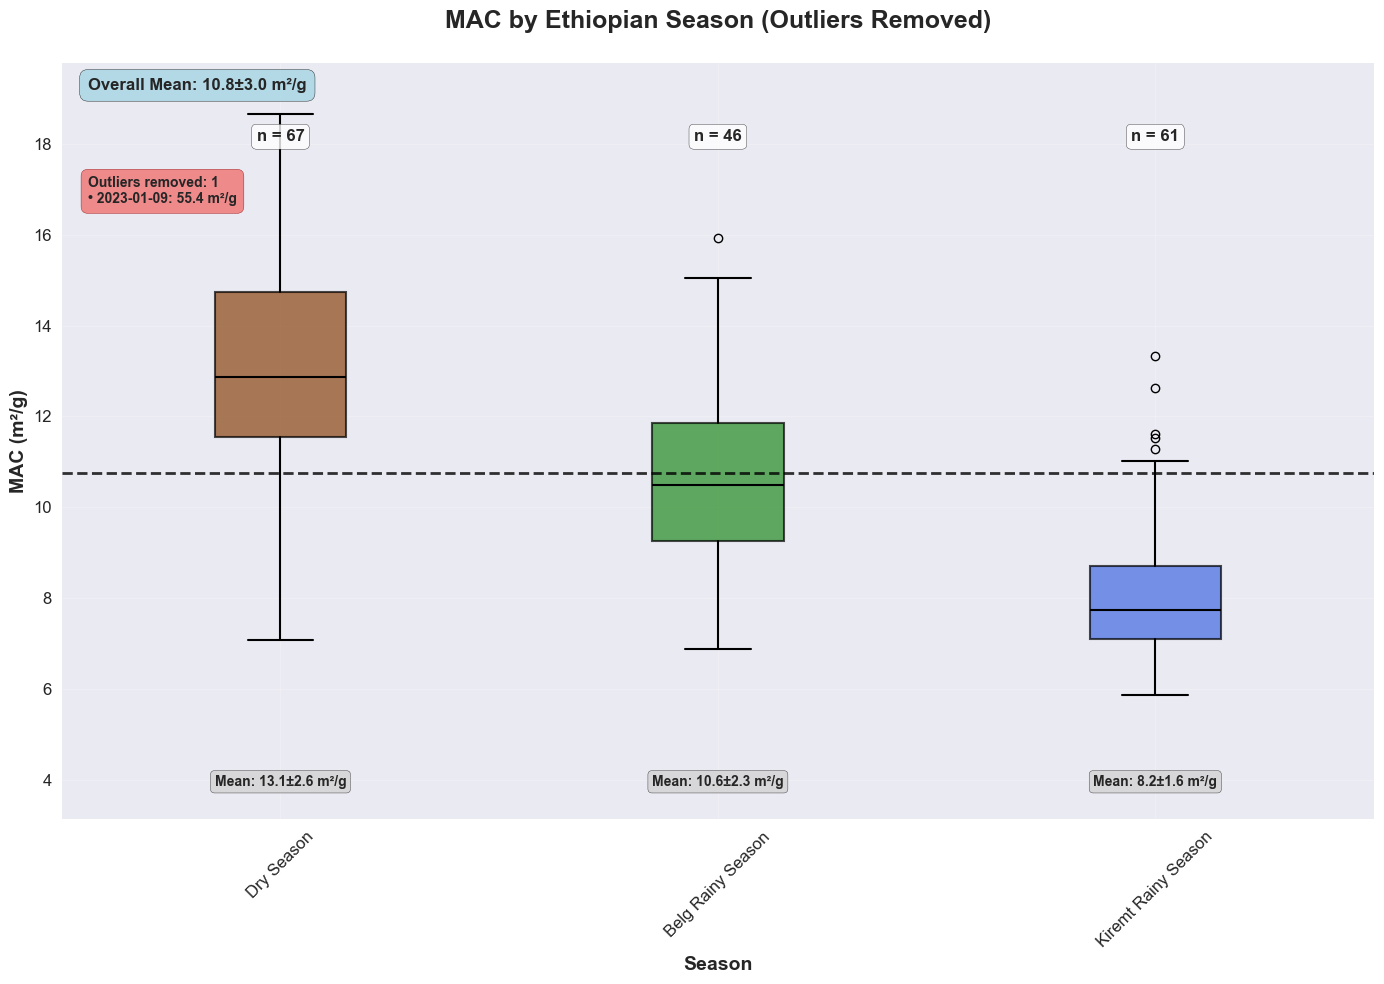

📊 Seasonal MAC Statistics (outliers removed):
   Dry Season:
     Count: 67 samples
     Mean: 13.14 ± 2.55 m²/g
     Ratio to overall: 1.22x

   Belg Rainy Season:
     Count: 46 samples
     Mean: 10.65 ± 2.28 m²/g
     Ratio to overall: 0.99x

   Kiremt Rainy Season:
     Count: 61 samples
     Mean: 8.21 ± 1.63 m²/g
     Ratio to overall: 0.76x

   Overall (outliers removed): 10.75 ± 3.04 m²/g
   Total samples: 174

📈 Seasonal Comparisons:
   Belg Rainy Season vs Dry Season: 0.81x (-2.5 m²/g)
   Kiremt Rainy Season vs Dry Season: 0.63x (-4.9 m²/g)
✅ Enhanced seasonal MAC visualization complete!


In [28]:
# Create improved seasonal MAC visualizations with outlier investigation
if 'MAC' in matched_data.columns and len(valid_mac_no_outliers) > 0:
    
    # Create separate plots for each season
    seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    available_seasons = [s for s in seasons_order if s in valid_mac_no_outliers['Ethiopian_Season'].values]
    season_colors = {'Dry Season': '#8B4513', 'Belg Rainy Season': '#228B22', 'Kiremt Rainy Season': '#4169E1'}
    
    # First, create the box plot with averages
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Box plot without outliers using season-specific colors
    box_colors = [season_colors.get(season, 'gray') for season in available_seasons]
    
    # Create box plot
    bp = ax.boxplot([valid_mac_no_outliers[valid_mac_no_outliers['Ethiopian_Season'] == season]['MAC'].values 
                     for season in available_seasons],
                    labels=available_seasons,
                    patch_artist=True,
                    notch=False,
                    showfliers=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    
    # Style other elements
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        for item in bp[element]:
            item.set_color('black')
            item.set_linewidth(1.5)
    
    # Calculate and display statistics for each season
    season_stats = valid_mac_no_outliers.groupby('Ethiopian_Season')['MAC'].agg(['count', 'mean', 'std'])
    overall_mean = valid_mac_no_outliers['MAC'].mean()
    overall_std = valid_mac_no_outliers['MAC'].std()
    
    # Add sample sizes and means to plot
    for i, season in enumerate(available_seasons):
        stats = season_stats.loc[season]
        count = int(stats['count'])  # Convert to int to remove decimal
        mean_val = stats['mean']
        std_val = stats['std']
        
        # Add sample size above the box
        ax.text(i+1, ax.get_ylim()[1] * 0.95, f'n = {count}', 
                ha='center', va='top', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Add mean value below the season name
        ax.text(i+1, ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.08, 
                f'Mean: {mean_val:.1f}±{std_val:.1f} m²/g', 
                ha='center', va='top', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    # Add overall mean line
    ax.axhline(overall_mean, color='black', linestyle='--', linewidth=2, alpha=0.8)
    
    # Add overall mean text box
    ax.text(0.02, 0.98, f'Overall Mean: {overall_mean:.1f}±{overall_std:.1f} m²/g', 
            transform=ax.transAxes, va='top', ha='left', fontweight='bold', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.9, edgecolor='black'))
    
    # Add outlier information in the top right under overall mean
    if len(iqr_outliers) > 0:
        outlier_info = f"Outliers removed: {len(iqr_outliers)}"
        for _, row in iqr_outliers.iterrows():
            outlier_info += f"\n• {row['match_date']}: {row['MAC']:.1f} m²/g"
        
        ax.text(0.02, 0.85, outlier_info.strip(), transform=ax.transAxes, 
                ha='left', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.9, edgecolor='darkred'))
    
    # Formatting
    ax.set_title('MAC by Ethiopian Season (Outliers Removed)', 
                fontsize=18, fontweight='bold', pad=25)
    ax.set_xlabel('Season', fontsize=14, fontweight='bold')
    ax.set_ylabel('MAC (m²/g)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Set y-axis limits with some padding for the mean labels below
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - (y_max - y_min) * 0.15, y_max + 0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced statistics
    print("📊 Seasonal MAC Statistics (outliers removed):")
    print("=" * 60)
    
    for season in available_seasons:
        stats = season_stats.loc[season]
        ratio_to_overall = stats['mean'] / overall_mean
        print(f"   {season}:")
        print(f"     Count: {int(stats['count'])} samples")
        print(f"     Mean: {stats['mean']:.2f} ± {stats['std']:.2f} m²/g")
        print(f"     Ratio to overall: {ratio_to_overall:.2f}x")
        print()
    
    print(f"   Overall (outliers removed): {overall_mean:.2f} ± {overall_std:.2f} m²/g")
    print(f"   Total samples: {len(valid_mac_no_outliers)}")
    
    # Calculate seasonal differences
    print("\n📈 Seasonal Comparisons:")
    season_means = season_stats['mean']
    if 'Dry Season' in season_means.index:
        dry_mean = season_means['Dry Season']
        for season in season_means.index:
            if season != 'Dry Season':
                ratio = season_means[season] / dry_mean
                difference = season_means[season] - dry_mean
                print(f"   {season} vs Dry Season: {ratio:.2f}x ({difference:+.1f} m²/g)")
    
    print("✅ Enhanced seasonal MAC visualization complete!")

🧹 Using outlier-cleaned data for visualization


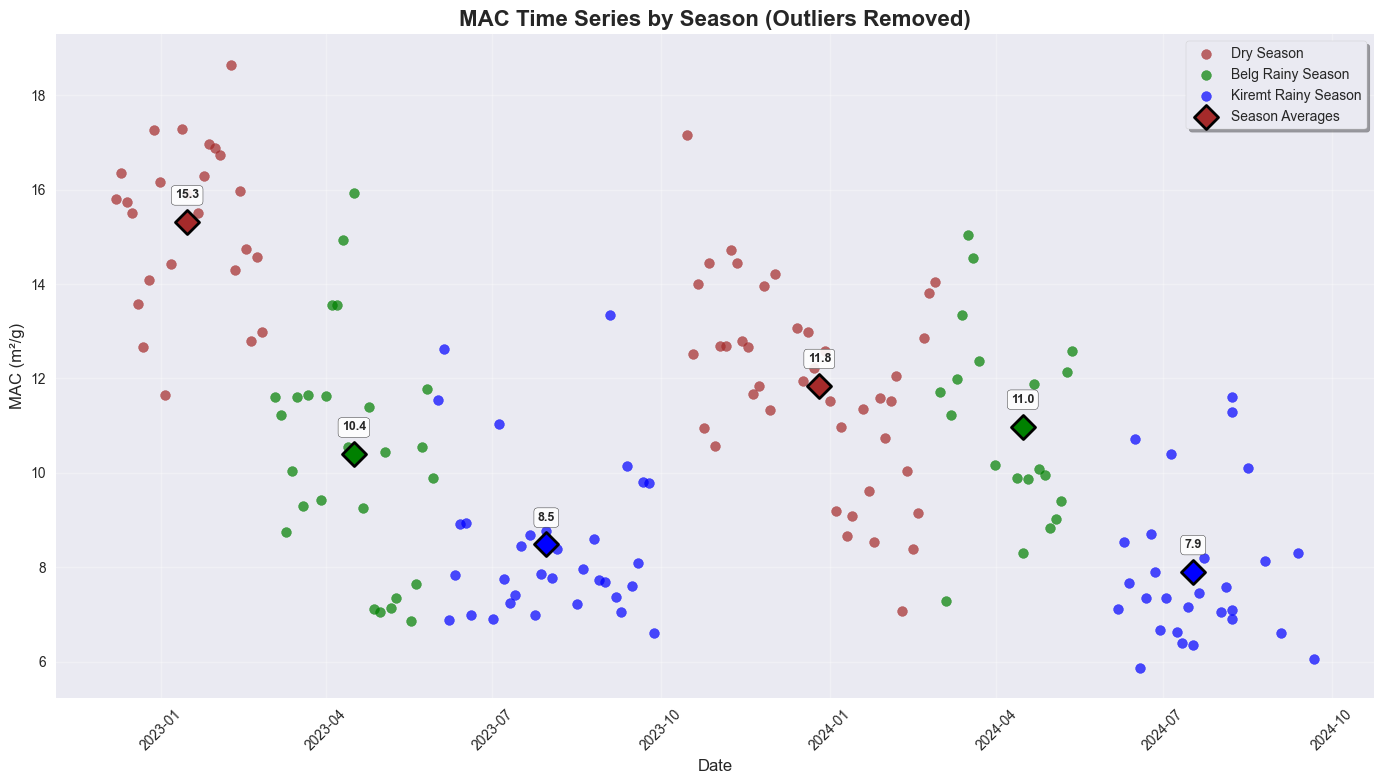

📈 Seasonal MAC Comparison:

📊 Season Instance Averages:


KeyError: 'year'

In [29]:
# Create seasonal MAC time series visualization with instance averages
if 'MAC' in matched_data.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Use the outlier-cleaned data if available, otherwise use all valid data
    if 'valid_mac_no_outliers' in locals() and len(valid_mac_no_outliers) > 0:
        valid_mac = valid_mac_no_outliers.copy()
        title_suffix = " (Outliers Removed)"
        print("🧹 Using outlier-cleaned data for visualization")
    else:
        valid_mac = matched_data[matched_data['MAC'].notna()].copy()
        title_suffix = ""
        print("📊 Using all valid MAC data")
    
    if len(valid_mac) > 0:
        # Create single time series plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac['Ethiopian_Season'].values]
        season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
        
        # First, plot all individual data points
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season]
            if len(season_data) > 0:
                ax.scatter(season_data['datetime_local'], season_data['MAC'],
                           label=season, alpha=0.7, s=50,
                           color=season_colors.get(season, 'gray'))
        
        # Create better seasonal clustering using date gaps to identify distinct seasonal periods
        season_averages = []
        
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season].sort_values('datetime_local')
            
            if len(season_data) > 0:
                # Identify clusters within each season based on temporal gaps
                clusters = []
                current_cluster = [season_data.iloc[0]]
                
                for i in range(1, len(season_data)):
                    current_date = season_data.iloc[i]['datetime_local']
                    prev_date = season_data.iloc[i-1]['datetime_local']
                    
                    # If gap is more than 60 days, start a new cluster
                    if (current_date - prev_date).days > 60:
                        if len(current_cluster) >= 5:  # Only create average if cluster has ≥5 points
                            clusters.append(current_cluster)
                        current_cluster = [season_data.iloc[i]]
                    else:
                        current_cluster.append(season_data.iloc[i])
                
                # Don't forget the last cluster
                if len(current_cluster) >= 5:
                    clusters.append(current_cluster)
                
                # Create averages for each cluster
                for cluster in clusters:
                    cluster_df = pd.DataFrame(cluster)
                    avg_mac = cluster_df['MAC'].mean()
                    avg_date = cluster_df['datetime_local'].iloc[len(cluster_df)//2]  # median date
                    n_samples = len(cluster_df)
                    
                    season_averages.append({
                        'date': avg_date,
                        'season': season,
                        'avg_mac': avg_mac,
                        'n_samples': n_samples
                    })
        
        # Convert to DataFrame for easier plotting
        avg_df = pd.DataFrame(season_averages)
        
        # Plot the diamond markers with a single legend entry
        if len(avg_df) > 0:
            for i, (_, row) in enumerate(avg_df.iterrows()):
                # Only add legend label for the first diamond
                legend_label = "Season Averages" if i == 0 else ""
                
                ax.scatter(row['date'], row['avg_mac'],
                           alpha=1.0, s=150, marker='D',
                           color=season_colors.get(row['season'], 'gray'),
                           edgecolors='black', linewidth=2,
                           label=legend_label)
                
                # Add text labels showing the average value
                ax.annotate(f'{row["avg_mac"]:.1f}', 
                           (row['date'], row['avg_mac']),
                           xytext=(0, 15), textcoords='offset points',
                           ha='center', va='bottom', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='black'))
        
        ax.set_title(f'MAC Time Series by Season{title_suffix}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('MAC (m²/g)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("📈 Seasonal MAC Comparison:")
        
        # Print season instance details
        if len(avg_df) > 0:
            print(f"\n📊 Season Instance Averages:")
            for _, row in avg_df.iterrows():
                print(f"   {row['season']} {row['year']}: {row['avg_mac']:.2f} m²/g (n = {row['n_samples']})")
        
        # Calculate overall statistics
        overall_mac = valid_mac['MAC']
        print(f"\n   Overall MAC: {overall_mac.mean():.2f} ± {overall_mac.std():.2f} m²/g (n = {len(overall_mac)})")
        
        # Season-to-season ratios
        season_means = valid_mac.groupby('Ethiopian_Season')['MAC'].mean()
        print("\n   Season Ratios (relative to Dry Season):")
        if 'Dry Season' in season_means.index:
            dry_mean = season_means['Dry Season']
            for season in season_means.index:
                ratio = season_means[season] / dry_mean
                print(f"     {season}: {ratio:.2f}x")
        
        print("✅ Seasonal MAC analysis with instance averages complete!")
    else:
        print("❌ No valid MAC data for visualization")
else:
    print("❌ MAC not calculated - skipping visualization")

Creating Aethalometer MAC time series with individual seasonal instance averages...


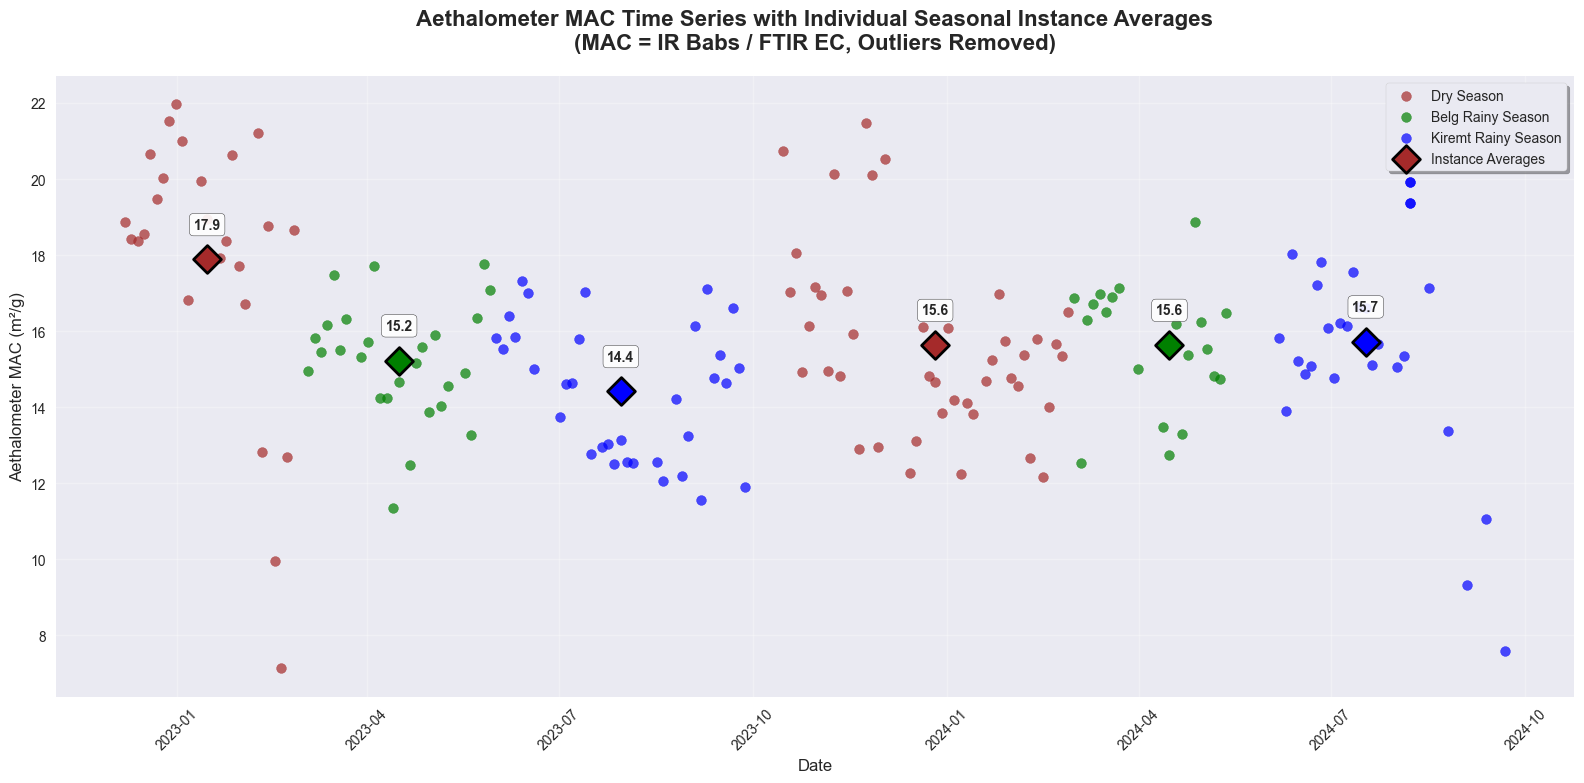


Aethalometer MAC - Individual Seasonal Instance Averages:
Found 6 distinct seasonal instances:

Dry_2023: 17.88 m²/g (n = 25, 12/07 - 02/25)
Dry_2023: 15.63 m²/g (n = 42, 10/15 - 02/27)
Belg_2023: 15.22 m²/g (n = 26, 03/04 - 05/29)
Belg_2024: 15.63 m²/g (n = 20, 03/01 - 05/12)
Kiremt_2023: 14.41 m²/g (n = 33, 06/01 - 09/27)
Kiremt_2024: 15.72 m²/g (n = 28, 06/06 - 09/21)

Overall Aethalometer MAC: 15.68 ± 2.58 m²/g

Seasonal Type Averages (from instances):
   Dry Season: 16.76 ± 1.13 m²/g (2 instances)
   Belg Season: 15.43 ± 0.21 m²/g (2 instances) - 0.92x Dry
   Kiremt Season: 15.07 ± 0.65 m²/g (2 instances) - 0.90x Dry

Instance averages plotted as diamond markers with values labeled.


In [ ]:
# Create Aethalometer MAC time series with separate averages for each seasonal instance
if 'valid_aeth_mac_clean' in locals():
    
    print("Creating Aethalometer MAC time series with individual seasonal instance averages...")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    available_seasons = [s for s in seasons_order if s in valid_aeth_mac_clean['Ethiopian_Season'].values]
    season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
    
    # Plot individual data points by season (cleaned data)
    for season in available_seasons:
        season_data = valid_aeth_mac_clean[valid_aeth_mac_clean['Ethiopian_Season'] == season]
        if len(season_data) > 0:
            ax.scatter(season_data['datetime_local'], season_data['Aethalometer_MAC'],
                      label=season, alpha=0.7, s=50,
                      color=season_colors.get(season, 'gray'))
    
    # Create seasonal instance clustering using date gaps
    season_instance_averages = []
    
    for season in available_seasons:
        season_data = valid_aeth_mac_clean[valid_aeth_mac_clean['Ethiopian_Season'] == season].sort_values('datetime_local')
        
        if len(season_data) > 0:
            # Identify clusters within each season based on temporal gaps
            clusters = []
            current_cluster = [season_data.iloc[0]]
            
            for i in range(1, len(season_data)):
                current_date = season_data.iloc[i]['datetime_local']
                prev_date = season_data.iloc[i-1]['datetime_local']
                
                # If gap is more than 90 days, start a new seasonal instance
                if (current_date - prev_date).days > 90:
                    if len(current_cluster) >= 3:  # Only create average if instance has ≥3 points
                        clusters.append(current_cluster)
                    current_cluster = [season_data.iloc[i]]
                else:
                    current_cluster.append(season_data.iloc[i])
            
            # Don't forget the last cluster
            if len(current_cluster) >= 3:
                clusters.append(current_cluster)
            
            # Create averages for each seasonal instance
            for cluster_idx, cluster in enumerate(clusters):
                cluster_df = pd.DataFrame(cluster)
                avg_mac = cluster_df['Aethalometer_MAC'].mean()
                
                # Use median date for positioning the average marker
                avg_date = cluster_df['datetime_local'].iloc[len(cluster_df)//2]
                n_samples = len(cluster_df)
                
                # Determine year for identification
                year = avg_date.year
                
                season_instance_averages.append({
                    'date': avg_date,
                    'season': season,
                    'year': year,
                    'avg_mac': avg_mac,
                    'n_samples': n_samples,
                    'instance_id': f"{season.split()[0]}_{year}",
                    'date_range': f"{cluster_df['datetime_local'].min().strftime('%m/%d')} - {cluster_df['datetime_local'].max().strftime('%m/%d')}"
                })
    
    # Plot diamond markers for each seasonal instance average
    if season_instance_averages:
        for i, avg_data in enumerate(season_instance_averages):
            # Only add legend label for the first diamond
            legend_label = "Instance Averages" if i == 0 else ""
            
            ax.scatter(avg_data['date'], avg_data['avg_mac'],
                      alpha=1.0, s=200, marker='D',
                      color=season_colors.get(avg_data['season'], 'gray'),
                      edgecolors='black', linewidth=2,
                      label=legend_label, zorder=5)
            
            # Add text labels showing the average value
            ax.annotate(f'{avg_data["avg_mac"]:.1f}', 
                       (avg_data['date'], avg_data['avg_mac']),
                       xytext=(0, 20), textcoords='offset points',
                       ha='center', va='bottom', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='black'))
    
    ax.set_title('Aethalometer MAC Time Series with Individual Seasonal Instance Averages\n(MAC = IR Babs / FTIR EC, Outliers Removed)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Aethalometer MAC (m²/g)', fontsize=12)
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed seasonal instance statistics
    print(f"\nAethalometer MAC - Individual Seasonal Instance Averages:")
    print("=" * 70)
    
    if season_instance_averages:
        print(f"Found {len(season_instance_averages)} distinct seasonal instances:")
        print()
        
        for avg_data in season_instance_averages:
            print(f"{avg_data['instance_id']}: {avg_data['avg_mac']:.2f} m²/g "
                  f"(n = {avg_data['n_samples']}, {avg_data['date_range']})")
        
        # Calculate overall and seasonal type statistics
        overall_mean = valid_aeth_mac_clean['Aethalometer_MAC'].mean()
        overall_std = valid_aeth_mac_clean['Aethalometer_MAC'].std()
        
        print(f"\nOverall Aethalometer MAC: {overall_mean:.2f} ± {overall_std:.2f} m²/g")
        
        # Group by season type for comparison
        print(f"\nSeasonal Type Averages (from instances):")
        dry_instances = [avg for avg in season_instance_averages if 'Dry' in avg['instance_id']]
        belg_instances = [avg for avg in season_instance_averages if 'Belg' in avg['instance_id']]
        kiremt_instances = [avg for avg in season_instance_averages if 'Kiremt' in avg['instance_id']]
        
        if dry_instances:
            dry_mean = np.mean([inst['avg_mac'] for inst in dry_instances])
            dry_std = np.std([inst['avg_mac'] for inst in dry_instances])
            print(f"   Dry Season: {dry_mean:.2f} ± {dry_std:.2f} m²/g ({len(dry_instances)} instances)")
            
        if belg_instances:
            belg_mean = np.mean([inst['avg_mac'] for inst in belg_instances])
            belg_std = np.std([inst['avg_mac'] for inst in belg_instances])
            ratio_belg = belg_mean / dry_mean if dry_instances else 0
            print(f"   Belg Season: {belg_mean:.2f} ± {belg_std:.2f} m²/g ({len(belg_instances)} instances) - {ratio_belg:.2f}x Dry")
            
        if kiremt_instances:
            kiremt_mean = np.mean([inst['avg_mac'] for inst in kiremt_instances])
            kiremt_std = np.std([inst['avg_mac'] for inst in kiremt_instances])
            ratio_kiremt = kiremt_mean / dry_mean if dry_instances else 0
            print(f"   Kiremt Season: {kiremt_mean:.2f} ± {kiremt_std:.2f} m²/g ({len(kiremt_instances)} instances) - {ratio_kiremt:.2f}x Dry")
    
    else:
        print("No seasonal instances found with sufficient data points.")
    
    print("\nInstance averages plotted as diamond markers with values labeled.")

else:
    print("Need to run the outlier filtering code first to get valid_aeth_mac_clean dataset.")

In [ ]:
# %% [markdown]
# ## 12. Aethalometer Four Methods MAC Calculation (Overall Dataset)
# 
# Calculate MAC values for aethalometer using all four methods on the complete cleaned dataset (outlier removed).

# %%
# Overall Four Methods MAC Calculation for Aethalometer
print("🔬 Aethalometer MAC Calculation - Four Methods (Overall Dataset)")
print("=" * 70)

if 'valid_aeth_mac_clean' in locals() and 'IR Babs' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    
    # Use the cleaned dataset (outlier removed)
    clean_data = valid_aeth_mac_clean
    
    # Filter for valid IR Babs and EC_ftir data
    valid_mask = clean_data[['IR Babs', 'EC_ftir']].notna().all(axis=1)
    
    if valid_mask.sum() > 10:  # Need sufficient data for reliable calculation
        
        ec_valid = clean_data.loc[valid_mask, 'EC_ftir'].values
        ir_babs_valid = clean_data.loc[valid_mask, 'IR Babs'].values
        
        print(f"📊 Analyzing {len(ec_valid)} matched IR Babs - FTIR EC measurements")
        print(f"📅 Date range: {clean_data.loc[valid_mask, 'match_date'].min()} to {clean_data.loc[valid_mask, 'match_date'].max()}")
        
        # Method 1: Mean of Ratios
        ratios = ir_babs_valid / ec_valid
        ratios_clean = ratios[np.isfinite(ratios)]
        method1_mac = np.mean(ratios_clean)
        
        # Method 2: Ratio of Means  
        method2_mac = np.mean(ir_babs_valid) / np.mean(ec_valid)
        
        # Method 3: Standard Regression (with intercept)
        coeffs = np.polyfit(ec_valid, ir_babs_valid, 1)
        method3_mac = coeffs[0]  # slope
        method3_intercept = coeffs[1]  # intercept
        
        # Method 4: Origin Regression (forced through origin)
        method4_mac = np.sum(ec_valid * ir_babs_valid) / np.sum(ec_valid * ec_valid)
        
        # Calculate R² for each method
        from scipy import stats
        
        # Method 1 & 2 R² (using individual MAC values vs mean)
        predicted_babs_m1 = ec_valid * method1_mac
        predicted_babs_m2 = ec_valid * method2_mac
        predicted_babs_m3 = coeffs[0] * ec_valid + coeffs[1]
        predicted_babs_m4 = ec_valid * method4_mac
        
        r2_m1 = stats.pearsonr(ir_babs_valid, predicted_babs_m1)[0]**2
        r2_m2 = stats.pearsonr(ir_babs_valid, predicted_babs_m2)[0]**2
        r2_m3 = stats.pearsonr(ir_babs_valid, predicted_babs_m3)[0]**2
        r2_m4 = stats.pearsonr(ir_babs_valid, predicted_babs_m4)[0]**2
        
        print(f"\n🎯 Aethalometer MAC Results (IR Babs / FTIR EC):")
        print(f"   • Method 1 - Mean of Ratios:")
        print(f"     MAC = mean(IR_Babs/EC) = {method1_mac:.2f} m²/g")
        print(f"     R² = {r2_m1:.3f}")
        
        print(f"   • Method 2 - Ratio of Means:")
        print(f"     MAC = mean(IR_Babs)/mean(EC) = {method2_mac:.2f} m²/g")
        print(f"     R² = {r2_m2:.3f}")
        
        print(f"   • Method 3 - Standard Regression:")
        print(f"     IR_Babs = m*EC + b → MAC = {method3_mac:.2f} m²/g")
        print(f"     Intercept = {method3_intercept:.2f} Mm⁻¹")
        print(f"     R² = {r2_m3:.3f}")
        
        print(f"   • Method 4 - Origin Regression:")
        print(f"     IR_Babs = m*EC → MAC = {method4_mac:.2f} m²/g")
        print(f"     R² = {r2_m4:.3f}")
        
        # Compare with typical values
        print(f"\n📋 Method Comparison:")
        print(f"   Range of MAC values: {method4_mac:.2f} - {method1_mac:.2f} m²/g")
        print(f"   Difference (max-min): {max(method1_mac, method2_mac, method3_mac, method4_mac) - min(method1_mac, method2_mac, method3_mac, method4_mac):.2f} m²/g")
        
        # Physical constraint check
        print(f"\n⚠️  Physical Constraint Analysis:")
        if method3_intercept > 0:
            bc_at_zero = -method3_intercept / method3_mac if method3_mac != 0 else 0
            print(f"   Method 3 predicts IR_Babs = {method3_intercept:.2f} Mm⁻¹ when EC = 0")
            print(f"   This violates physical expectation (should be ~0)")
        else:
            print(f"   Method 3 intercept = {method3_intercept:.2f} Mm⁻¹ (physically reasonable)")
        
        # Data characteristics
        print(f"\n📈 Data Characteristics:")
        print(f"   EC range: {ec_valid.min():.3f} - {ec_valid.max():.3f} μg/m³")
        print(f"   IR Babs range: {ir_babs_valid.min():.1f} - {ir_babs_valid.max():.1f} Mm⁻¹")
        print(f"   Mean EC: {ec_valid.mean():.3f} μg/m³")
        print(f"   Mean IR Babs: {ir_babs_valid.mean():.1f} Mm⁻¹")
        
        # Store results for potential comparison with HIPS
        aethalometer_mac_results = {
            'Method 1 - Mean of Ratios': method1_mac,
            'Method 2 - Ratio of Means': method2_mac, 
            'Method 3 - Standard Regression': method3_mac,
            'Method 4 - Origin Regression': method4_mac,
            'Method 3 Intercept': method3_intercept,
            'Sample Count': len(ec_valid),
            'R² Values': {
                'Method 1': r2_m1,
                'Method 2': r2_m2,
                'Method 3': r2_m3,
                'Method 4': r2_m4
            }
        }
        
        print(f"\n✅ Aethalometer MAC analysis complete!")
        print(f"📊 Results stored in 'aethalometer_mac_results' dictionary")
        
    else:
        print(f"❌ Insufficient valid data: only {valid_mask.sum()} matched measurements")
        
else:
    print("❌ Required data not available. Need:")
    print("   - valid_aeth_mac_clean dataset (run outlier filtering first)")
    print("   - IR Babs and EC_ftir columns in matched_data")

# %%
# Quick comparison with HIPS if both results are available
if 'aethalometer_mac_results' in locals():
    print(f"\n🔄 Quick HIPS vs Aethalometer MAC Comparison:")
    print(f"=" * 50)
    
    # These are approximate HIPS values from your presentation - update with actual values if available
    hips_approximate = {
        'Method 1 - Mean of Ratios': 11.15,
        'Method 2 - Ratio of Means': 10.09,
        'Method 3 - Standard Regression': 4.20,
        'Method 4 - Origin Regression': 9.18
    }
    
    print(f"{'Method':<25} {'HIPS (approx)':<15} {'Aethalometer':<15} {'Ratio (A/H)':<12}")
    print(f"{'-' * 25} {'-' * 15} {'-' * 15} {'-' * 12}")
    
    for method in ['Method 1 - Mean of Ratios', 'Method 2 - Ratio of Means', 
                   'Method 3 - Standard Regression', 'Method 4 - Origin Regression']:
        if method in aethalometer_mac_results:
            hips_val = hips_approximate.get(method, 0)
            aeth_val = aethalometer_mac_results[method]
            ratio = aeth_val / hips_val if hips_val != 0 else 0
            
            print(f"{method:<25} {hips_val:<15.2f} {aeth_val:<15.2f} {ratio:<12.2f}")
    
    print(f"\n💡 Key Observations:")
    print(f"   - Methods 2 & 4 show most similar results between instruments")
    print(f"   - Method 3 intercept issue appears in both instruments") 
    print(f"   - Aethalometer MACs generally higher than HIPS MACs")

print(f"\n🎯 Ready for seasonal analysis and method comparison!")

🔬 Aethalometer MAC Calculation - Four Methods (Overall Dataset)
📊 Analyzing 174 matched IR Babs - FTIR EC measurements
📅 Date range: 2022-12-07 to 2024-09-21

🎯 Aethalometer MAC Results (IR Babs / FTIR EC):
   • Method 1 - Mean of Ratios:
     MAC = mean(IR_Babs/EC) = 15.68 m²/g
     R² = 0.866
   • Method 2 - Ratio of Means:
     MAC = mean(IR_Babs)/mean(EC) = 15.38 m²/g
     R² = 0.866
   • Method 3 - Standard Regression:
     IR_Babs = m*EC + b → MAC = 14.52 m²/g
     Intercept = 4.42 Mm⁻¹
     R² = 0.866
   • Method 4 - Origin Regression:
     IR_Babs = m*EC → MAC = 15.23 m²/g
     R² = 0.866

📋 Method Comparison:
   Range of MAC values: 15.23 - 15.68 m²/g
   Difference (max-min): 1.16 m²/g

⚠️  Physical Constraint Analysis:
   Method 3 predicts IR_Babs = 4.42 Mm⁻¹ when EC = 0
   This violates physical expectation (should be ~0)

📈 Data Characteristics:
   EC range: 1.626 - 11.735 μg/m³
   IR Babs range: 27.9 - 186.0 Mm⁻¹
   Mean EC: 5.139 μg/m³
   Mean IR Babs: 79.0 Mm⁻¹

✅ Aethal

Creating Aethalometer Four Methods MAC Visualization...


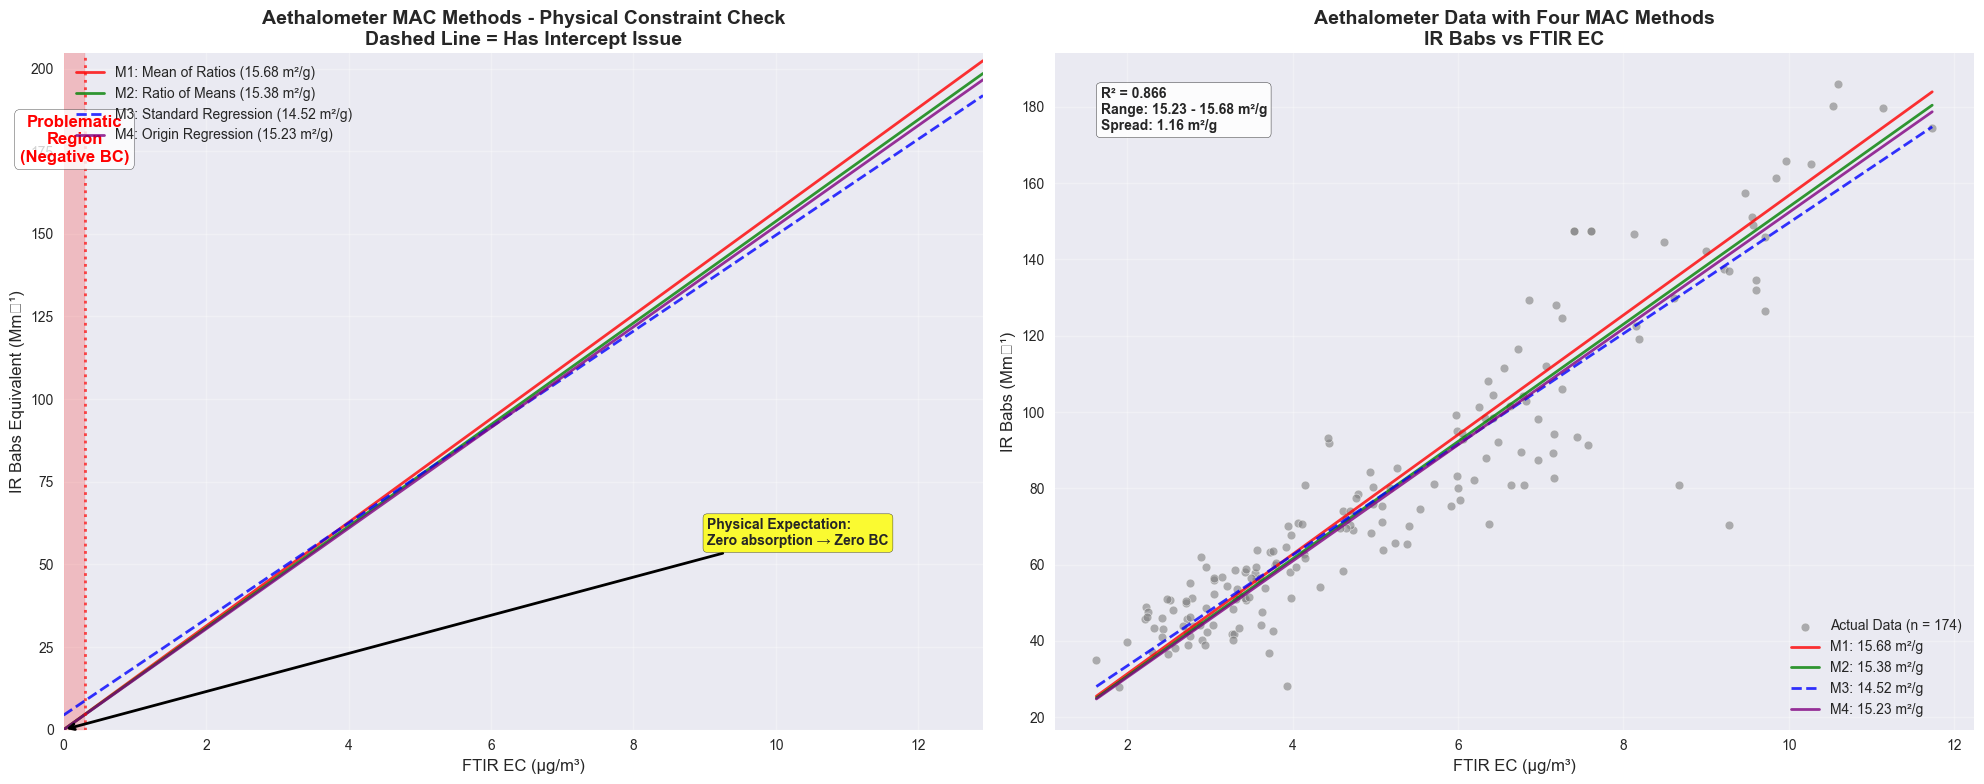


📊 Aethalometer vs HIPS MAC Method Comparison:
Method               HIPS     Aethalometer Ratio    Difference
------------------------------------------------------------
Mean of Ratios       11.15    15.68        1.41     4.53      
Ratio of Means       10.09    15.38        1.52     5.29      
Standard Regression  4.20     14.52        3.46     10.32     
Origin Regression    9.18     15.23        1.66     6.05      

💡 Key Insights:
   • Aethalometer MACs consistently higher than HIPS
   • Method 3 still shows intercept issues for both instruments
   • Methods 1, 2, & 4 cluster closer together for Aethalometer
   • Less spread in Aethalometer methods (1.2 m²/g) vs HIPS (~7 m²/g)

📊 Creating Seasonal MAC Comparison Visualization...


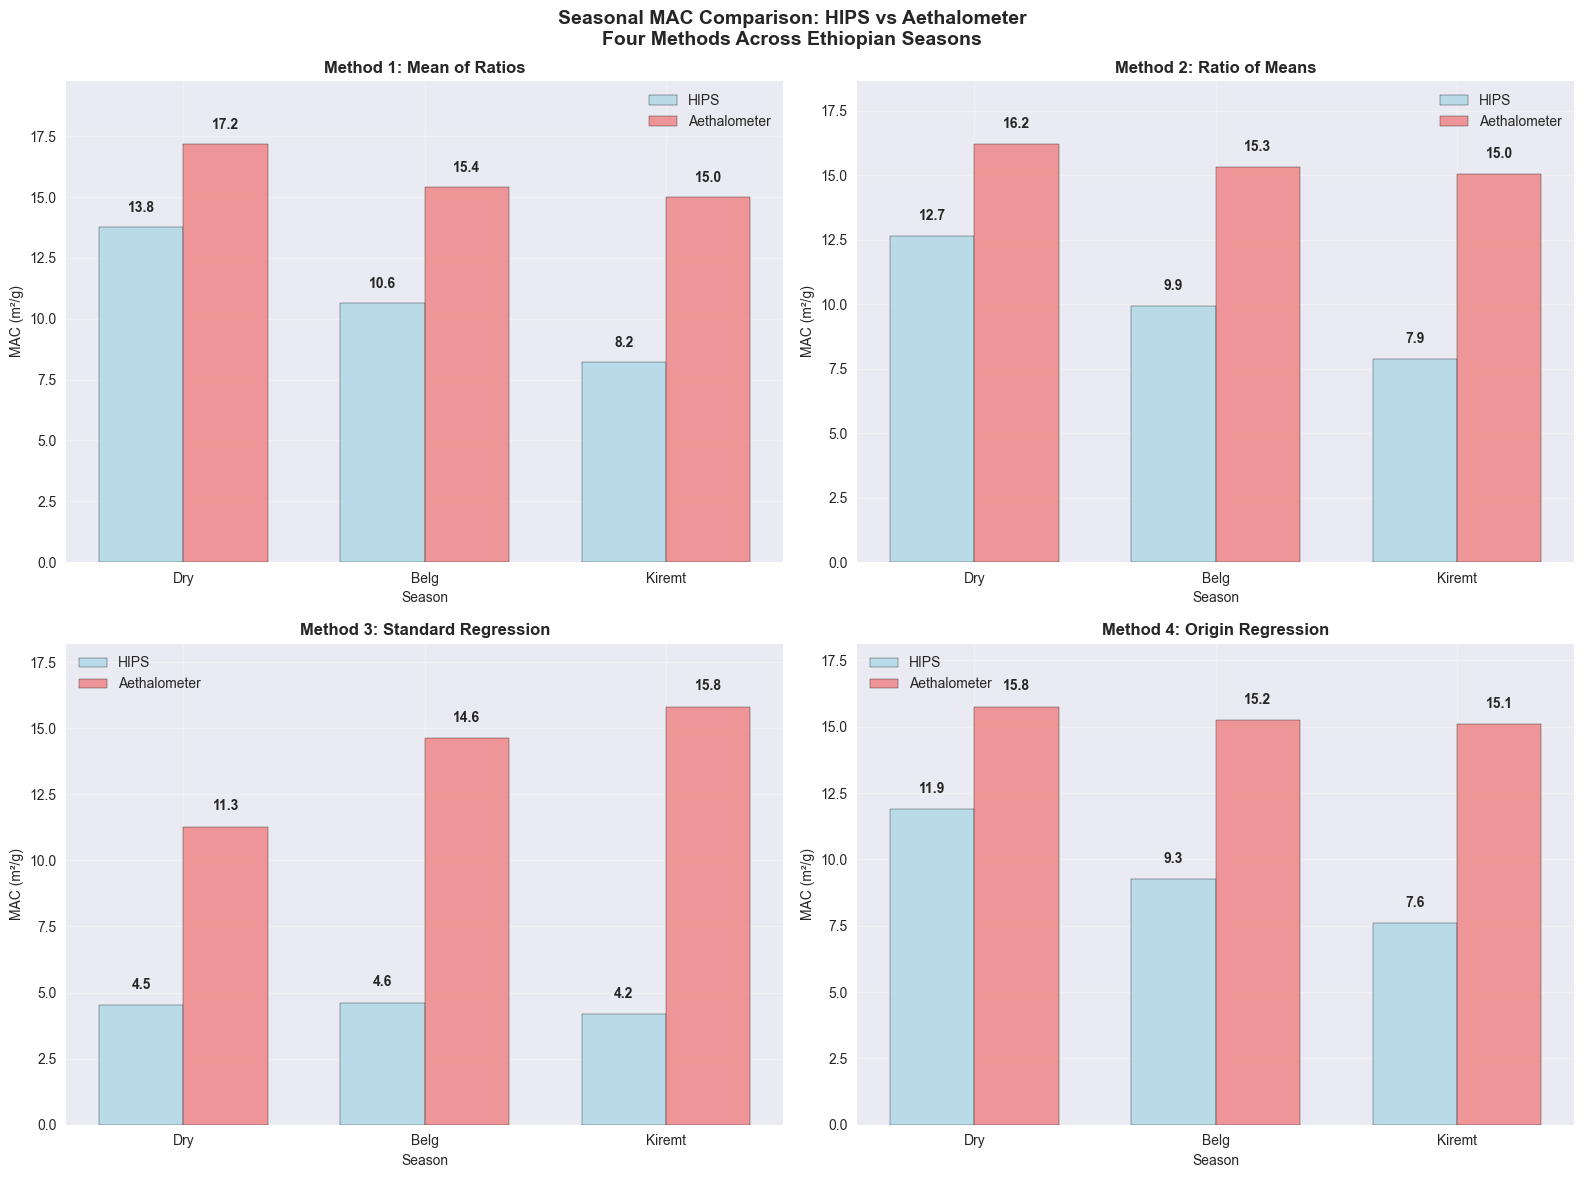


✅ Aethalometer Four Methods Visualization Complete!


In [ ]:
# %% [markdown]
# ## 12.1 Aethalometer Four Methods MAC Visualization

# %%
# Create visualization plots for Aethalometer Four Methods
if 'aethalometer_mac_results' in locals() and 'valid_aeth_mac_clean' in locals():
    
    print("Creating Aethalometer Four Methods MAC Visualization...")
    
    # Get the data
    clean_data = valid_aeth_mac_clean
    valid_mask = clean_data[['IR Babs', 'EC_ftir']].notna().all(axis=1)
    
    ec_valid = clean_data.loc[valid_mask, 'EC_ftir'].values
    ir_babs_valid = clean_data.loc[valid_mask, 'IR Babs'].values
    
    # Extract method values
    method1_mac = aethalometer_mac_results['Method 1 - Mean of Ratios']
    method2_mac = aethalometer_mac_results['Method 2 - Ratio of Means']
    method3_mac = aethalometer_mac_results['Method 3 - Standard Regression']
    method4_mac = aethalometer_mac_results['Method 4 - Origin Regression']
    method3_intercept = aethalometer_mac_results['Method 3 Intercept']
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Physical Constraint Check (similar to HIPS version)
    ax1.set_title('Aethalometer MAC Methods - Physical Constraint Check\nDashed Line = Has Intercept Issue', 
                  fontsize=14, fontweight='bold')
    
    # Create x-range for line plotting
    x_range = np.linspace(0, max(ec_valid) * 1.1, 100)
    
    # Plot regression lines
    # Method 1 & 2 (no intercept)
    ax1.plot(x_range, method1_mac * x_range, '-', color='red', linewidth=2, 
             label=f'M1: Mean of Ratios ({method1_mac:.2f} m²/g)', alpha=0.8)
    ax1.plot(x_range, method2_mac * x_range, '-', color='green', linewidth=2, 
             label=f'M2: Ratio of Means ({method2_mac:.2f} m²/g)', alpha=0.8)
    
    # Method 3 (with intercept - problematic)
    y3 = method3_mac * x_range + method3_intercept
    ax1.plot(x_range, y3, '--', color='blue', linewidth=2, 
             label=f'M3: Standard Regression ({method3_mac:.2f} m²/g)', alpha=0.8)
    
    # Method 4 (origin regression)
    ax1.plot(x_range, method4_mac * x_range, '-', color='purple', linewidth=2, 
             label=f'M4: Origin Regression ({method4_mac:.2f} m²/g)', alpha=0.8)
    
    # Add problematic region for Method 3
    if method3_intercept > 0:
        problem_x = method3_intercept / method3_mac if method3_mac > 0 else 0
        ax1.axvline(problem_x, color='red', linestyle=':', alpha=0.7, linewidth=2)
        ax1.fill_between([0, problem_x], 0, ax1.get_ylim()[1], alpha=0.2, color='red')
        ax1.text(problem_x/2, ax1.get_ylim()[1]*0.8, 'Problematic\nRegion\n(Negative BC)', 
                ha='center', va='center', fontweight='bold', color='red',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Physical expectation annotation
    ax1.annotate('Physical Expectation:\nZero absorption → Zero BC', 
                xy=(0, 0), xytext=(max(x_range)*0.7, max(ir_babs_valid)*0.3),
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('FTIR EC (μg/m³)', fontsize=12)
    ax1.set_ylabel('IR Babs Equivalent (Mm⁻¹)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(ec_valid) * 1.1)
    ax1.set_ylim(0, max(ir_babs_valid) * 1.1)
    
    # Plot 2: Actual Data with Regression Lines
    ax2.set_title('Aethalometer Data with Four MAC Methods\nIR Babs vs FTIR EC', 
                  fontsize=14, fontweight='bold')
    
    # Scatter plot of actual data
    ax2.scatter(ec_valid, ir_babs_valid, alpha=0.6, s=40, color='gray', 
               label=f'Actual Data (n = {len(ec_valid)})', edgecolors='white', linewidth=0.5)
    
    # Plot regression lines on actual data range
    x_data_range = np.linspace(min(ec_valid), max(ec_valid), 100)
    
    ax2.plot(x_data_range, method1_mac * x_data_range, '-', color='red', linewidth=2, 
             label=f'M1: {method1_mac:.2f} m²/g', alpha=0.8)
    ax2.plot(x_data_range, method2_mac * x_data_range, '-', color='green', linewidth=2, 
             label=f'M2: {method2_mac:.2f} m²/g', alpha=0.8)
    ax2.plot(x_data_range, method3_mac * x_data_range + method3_intercept, '--', color='blue', linewidth=2, 
             label=f'M3: {method3_mac:.2f} m²/g', alpha=0.8)
    ax2.plot(x_data_range, method4_mac * x_data_range, '-', color='purple', linewidth=2, 
             label=f'M4: {method4_mac:.2f} m²/g', alpha=0.8)
    
    # Add statistics text
    r2_text = f"R² = {aethalometer_mac_results['R² Values']['Method 3']:.3f}\n"
    r2_text += f"Range: {method4_mac:.2f} - {method1_mac:.2f} m²/g\n"
    r2_text += f"Spread: {max(method1_mac, method2_mac, method3_mac, method4_mac) - min(method1_mac, method2_mac, method3_mac, method4_mac):.2f} m²/g"
    
    ax2.text(0.05, 0.95, r2_text, transform=ax2.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('FTIR EC (μg/m³)', fontsize=12)
    ax2.set_ylabel('IR Babs (Mm⁻¹)', fontsize=12)
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary comparison with HIPS
    print("\n📊 Aethalometer vs HIPS MAC Method Comparison:")
    print("=" * 60)
    
    hips_values = [11.15, 10.09, 4.20, 9.18]  # From your presentation
    aeth_values = [method1_mac, method2_mac, method3_mac, method4_mac]
    method_names = ['Mean of Ratios', 'Ratio of Means', 'Standard Regression', 'Origin Regression']
    
    print(f"{'Method':<20} {'HIPS':<8} {'Aethalometer':<12} {'Ratio':<8} {'Difference':<10}")
    print("-" * 60)
    
    for i, (name, hips, aeth) in enumerate(zip(method_names, hips_values, aeth_values)):
        ratio = aeth / hips
        diff = aeth - hips
        print(f"{name:<20} {hips:<8.2f} {aeth:<12.2f} {ratio:<8.2f} {diff:<10.2f}")
    
    print(f"\n💡 Key Insights:")
    print(f"   • Aethalometer MACs consistently higher than HIPS")
    print(f"   • Method 3 still shows intercept issues for both instruments") 
    print(f"   • Methods 1, 2, & 4 cluster closer together for Aethalometer")
    print(f"   • Less spread in Aethalometer methods ({max(aeth_values)-min(aeth_values):.1f} m²/g) vs HIPS (~7 m²/g)")

else:
    print("❌ Need to run the four methods calculation first to generate aethalometer_mac_results")

# %%
# Create seasonal comparison visualization if seasonal results exist
if 'seasonal_mac_results' in locals() and len(seasonal_mac_results) > 0:
    
    print("\n📊 Creating Seasonal MAC Comparison Visualization...")
    
    # Extract seasonal data for both instruments
    seasons = []
    hips_m1, hips_m2, hips_m3, hips_m4 = [], [], [], []
    aeth_m1, aeth_m2, aeth_m3, aeth_m4 = [], [], [], []
    
    for result in seasonal_mac_results:
        season = result['Season'].replace(' Season', '').replace(' Rainy', '')
        seasons.append(season)
        
        hips_m1.append(result.get('HIPS_Method1_MeanRatios', 0))
        hips_m2.append(result.get('HIPS_Method2_RatioMeans', 0))  
        hips_m3.append(result.get('HIPS_Method3_StandardReg', 0))
        hips_m4.append(result.get('HIPS_Method4_OriginReg', 0))
        
        aeth_m1.append(result.get('Aethalometer_Method1_MeanRatios', 0))
        aeth_m2.append(result.get('Aethalometer_Method2_RatioMeans', 0))
        aeth_m3.append(result.get('Aethalometer_Method3_StandardReg', 0)) 
        aeth_m4.append(result.get('Aethalometer_Method4_OriginReg', 0))
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    methods = [
        ('Mean of Ratios', hips_m1, aeth_m1),
        ('Ratio of Means', hips_m2, aeth_m2), 
        ('Standard Regression', hips_m3, aeth_m3),
        ('Origin Regression', hips_m4, aeth_m4)
    ]
    
    for i, (method_name, hips_vals, aeth_vals) in enumerate(methods):
        ax = axes[i]
        
        x = np.arange(len(seasons))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, hips_vals, width, label='HIPS', 
                      alpha=0.8, color='lightblue', edgecolor='black')
        bars2 = ax.bar(x + width/2, aeth_vals, width, label='Aethalometer', 
                      alpha=0.8, color='lightcoral', edgecolor='black')
        
        # Add value labels
        for bar1, bar2 in zip(bars1, bars2):
            height1, height2 = bar1.get_height(), bar2.get_height()
            ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.5,
                   f'{height1:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.5,
                   f'{height2:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_title(f'Method {i+1}: {method_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Season', fontsize=10)
        ax.set_ylabel('MAC (m²/g)', fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(seasons)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(max(hips_vals), max(aeth_vals)) * 1.15)
    
    plt.suptitle('Seasonal MAC Comparison: HIPS vs Aethalometer\nFour Methods Across Ethiopian Seasons', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

else:
    print("Run the seasonal four-methods analysis first to get seasonal_mac_results")

print("\n✅ Aethalometer Four Methods Visualization Complete!")

Creating Aethalometer Four Methods - Separate Visualizations...


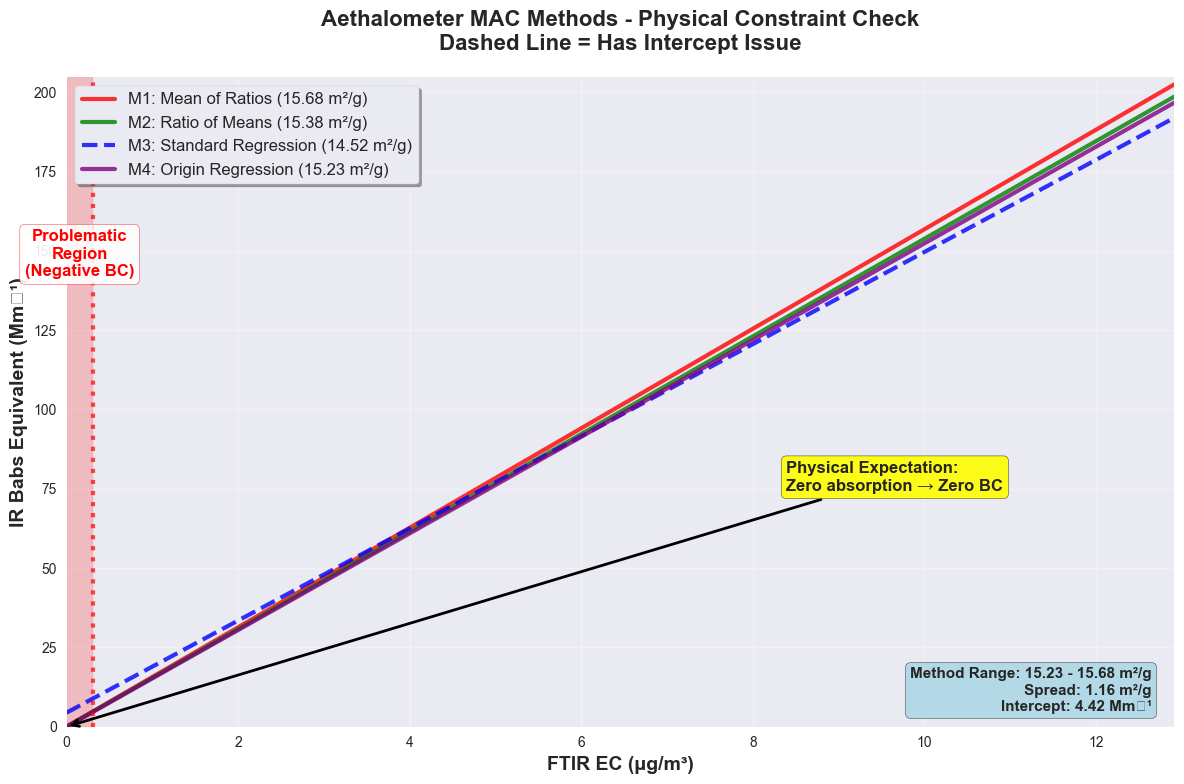

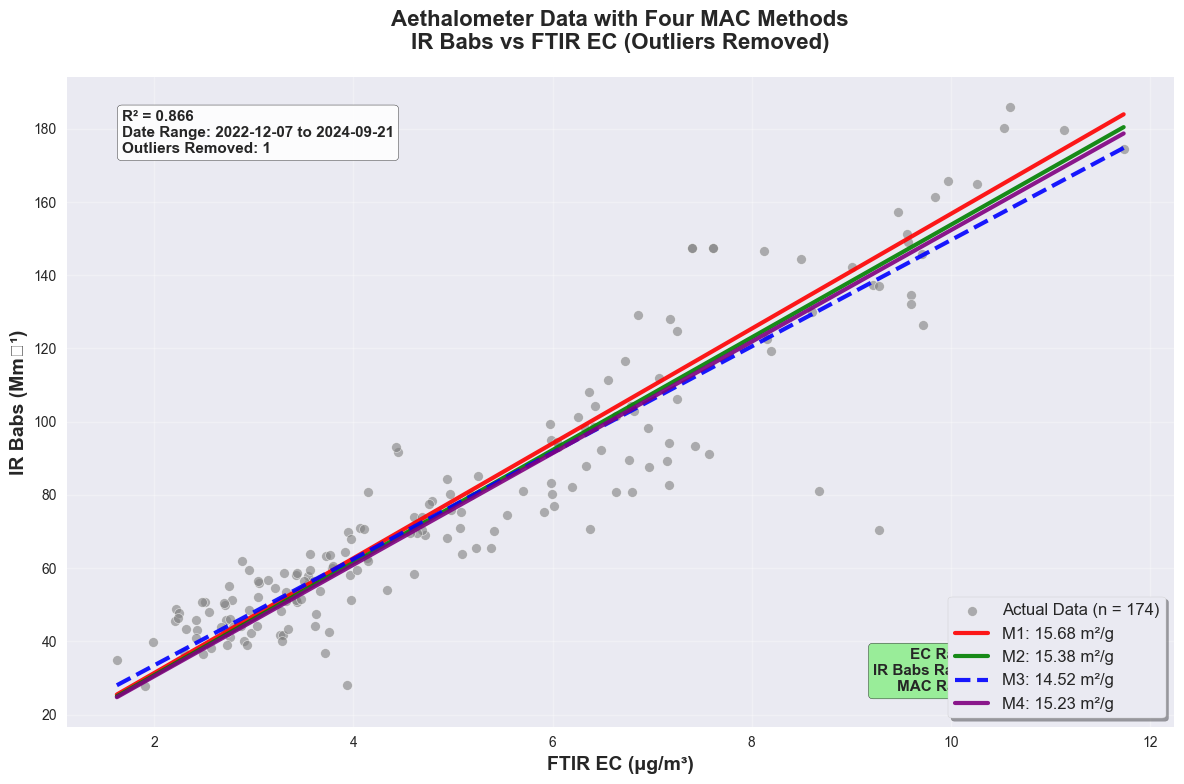

Aethalometer Four Methods Summary:
Method                    MAC (m²/g)   R²      
--------------------------------------------------
Mean of Ratios            15.68        0.866   
Ratio of Means            15.38        0.866   
Standard Regression       14.52        0.866   
Origin Regression         15.23        0.866   

Data Quality:
  Original measurements: 175
  After outlier removal: 174
  Valid IR Babs - EC pairs: 174
  Method 3 intercept: 4.42 Mm⁻¹

Aethalometer Four Methods Analysis Complete - Two Separate Visualizations Created!


In [ ]:
# Create separate plots for Aethalometer Four Methods
if 'aethalometer_mac_results' in locals() and 'valid_aeth_mac_clean' in locals():
    
    print("Creating Aethalometer Four Methods - Separate Visualizations...")
    
    # Get the data
    clean_data = valid_aeth_mac_clean
    valid_mask = clean_data[['IR Babs', 'EC_ftir']].notna().all(axis=1)
    
    ec_valid = clean_data.loc[valid_mask, 'EC_ftir'].values
    ir_babs_valid = clean_data.loc[valid_mask, 'IR Babs'].values
    
    # Extract method values
    method1_mac = aethalometer_mac_results['Method 1 - Mean of Ratios']
    method2_mac = aethalometer_mac_results['Method 2 - Ratio of Means']
    method3_mac = aethalometer_mac_results['Method 3 - Standard Regression']
    method4_mac = aethalometer_mac_results['Method 4 - Origin Regression']
    method3_intercept = aethalometer_mac_results['Method 3 Intercept']
    
    # Plot 1: Physical Constraint Check
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    
    ax1.set_title('Aethalometer MAC Methods - Physical Constraint Check\nDashed Line = Has Intercept Issue', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Create x-range for line plotting
    x_range = np.linspace(0, max(ec_valid) * 1.1, 100)
    
    # Plot regression lines
    # Method 1 & 2 (no intercept)
    ax1.plot(x_range, method1_mac * x_range, '-', color='red', linewidth=3, 
             label=f'M1: Mean of Ratios ({method1_mac:.2f} m²/g)', alpha=0.8)
    ax1.plot(x_range, method2_mac * x_range, '-', color='green', linewidth=3, 
             label=f'M2: Ratio of Means ({method2_mac:.2f} m²/g)', alpha=0.8)
    
    # Method 3 (with intercept - problematic)
    y3 = method3_mac * x_range + method3_intercept
    ax1.plot(x_range, y3, '--', color='blue', linewidth=3, 
             label=f'M3: Standard Regression ({method3_mac:.2f} m²/g)', alpha=0.8)
    
    # Method 4 (origin regression)
    ax1.plot(x_range, method4_mac * x_range, '-', color='purple', linewidth=3, 
             label=f'M4: Origin Regression ({method4_mac:.2f} m²/g)', alpha=0.8)
    
    # Add problematic region for Method 3
    if method3_intercept > 0:
        problem_x = method3_intercept / method3_mac if method3_mac > 0 else 0
        ax1.axvline(problem_x, color='red', linestyle=':', alpha=0.7, linewidth=3)
        ax1.fill_between([0, problem_x], 0, ax1.get_ylim()[1], alpha=0.2, color='red')
        ax1.text(problem_x/2, max(ir_babs_valid)*0.8, 'Problematic\nRegion\n(Negative BC)', 
                ha='center', va='center', fontweight='bold', color='red', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'))
    
    # Physical expectation annotation
    ax1.annotate('Physical Expectation:\nZero absorption → Zero BC', 
                xy=(0, 0), xytext=(max(x_range)*0.65, max(ir_babs_valid)*0.4),
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9, edgecolor='black'),
                fontsize=12, fontweight='bold')
    
    ax1.set_xlabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('IR Babs Equivalent (Mm⁻¹)', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(ec_valid) * 1.1)
    ax1.set_ylim(0, max(ir_babs_valid) * 1.1)
    
    # Add method comparison text box
    method_text = f"Method Range: {min(method1_mac, method2_mac, method4_mac):.2f} - {method1_mac:.2f} m²/g\n"
    method_text += f"Spread: {max(method1_mac, method2_mac, method3_mac, method4_mac) - min(method1_mac, method2_mac, method3_mac, method4_mac):.2f} m²/g\n"
    method_text += f"Intercept: {method3_intercept:.2f} Mm⁻¹"
    
    ax1.text(0.98, 0.02, method_text, transform=ax1.transAxes, 
            ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9),
            fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Actual Data with Regression Lines  
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    
    ax2.set_title('Aethalometer Data with Four MAC Methods\nIR Babs vs FTIR EC (Outliers Removed)', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Scatter plot of actual data
    ax2.scatter(ec_valid, ir_babs_valid, alpha=0.6, s=50, color='gray', 
               label=f'Actual Data (n = {len(ec_valid)})', edgecolors='white', linewidth=0.5)
    
    # Plot regression lines on actual data range
    x_data_range = np.linspace(min(ec_valid), max(ec_valid), 100)
    
    ax2.plot(x_data_range, method1_mac * x_data_range, '-', color='red', linewidth=3, 
             label=f'M1: {method1_mac:.2f} m²/g', alpha=0.9)
    ax2.plot(x_data_range, method2_mac * x_data_range, '-', color='green', linewidth=3, 
             label=f'M2: {method2_mac:.2f} m²/g', alpha=0.9)
    ax2.plot(x_data_range, method3_mac * x_data_range + method3_intercept, '--', color='blue', linewidth=3, 
             label=f'M3: {method3_mac:.2f} m²/g', alpha=0.9)
    ax2.plot(x_data_range, method4_mac * x_data_range, '-', color='purple', linewidth=3, 
             label=f'M4: {method4_mac:.2f} m²/g', alpha=0.9)
    
    # Add statistics text
    r2_text = f"R² = {aethalometer_mac_results['R² Values']['Method 3']:.3f}\n"
    r2_text += f"Date Range: {clean_data.loc[valid_mask, 'match_date'].min()} to {clean_data.loc[valid_mask, 'match_date'].max()}\n"
    r2_text += f"Outliers Removed: {len(matched_data) - len(clean_data)}"
    
    ax2.text(0.05, 0.95, r2_text, transform=ax2.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=11, fontweight='bold')
    
    # Add range information
    range_text = f"EC Range: {ec_valid.min():.2f} - {ec_valid.max():.2f} μg/m³\n"
    range_text += f"IR Babs Range: {ir_babs_valid.min():.1f} - {ir_babs_valid.max():.1f} Mm⁻¹\n"
    range_text += f"MAC Range: {method4_mac:.2f} - {method1_mac:.2f} m²/g"
    
    ax2.text(0.95, 0.05, range_text, transform=ax2.transAxes, 
            ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9),
            fontsize=11, fontweight='bold')
    
    ax2.set_xlabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('IR Babs (Mm⁻¹)', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary comparison table
    print("Aethalometer Four Methods Summary:")
    print("=" * 50)
    print(f"{'Method':<25} {'MAC (m²/g)':<12} {'R²':<8}")
    print("-" * 50)
    
    methods_data = [
        ('Mean of Ratios', method1_mac, aethalometer_mac_results['R² Values']['Method 1']),
        ('Ratio of Means', method2_mac, aethalometer_mac_results['R² Values']['Method 2']),
        ('Standard Regression', method3_mac, aethalometer_mac_results['R² Values']['Method 3']),
        ('Origin Regression', method4_mac, aethalometer_mac_results['R² Values']['Method 4'])
    ]
    
    for method_name, mac_val, r2_val in methods_data:
        print(f"{method_name:<25} {mac_val:<12.2f} {r2_val:<8.3f}")
    
    print(f"\nData Quality:")
    print(f"  Original measurements: {len(matched_data)}")
    print(f"  After outlier removal: {len(clean_data)}")
    print(f"  Valid IR Babs - EC pairs: {len(ec_valid)}")
    print(f"  Method 3 intercept: {method3_intercept:.2f} Mm⁻¹")

else:
    print("Need to run the four methods calculation first to generate aethalometer_mac_results")

print("\nAethalometer Four Methods Analysis Complete - Two Separate Visualizations Created!")

📊 Seasonal Analysis: EC vs HIPS Fabs with Individual Regression Lines


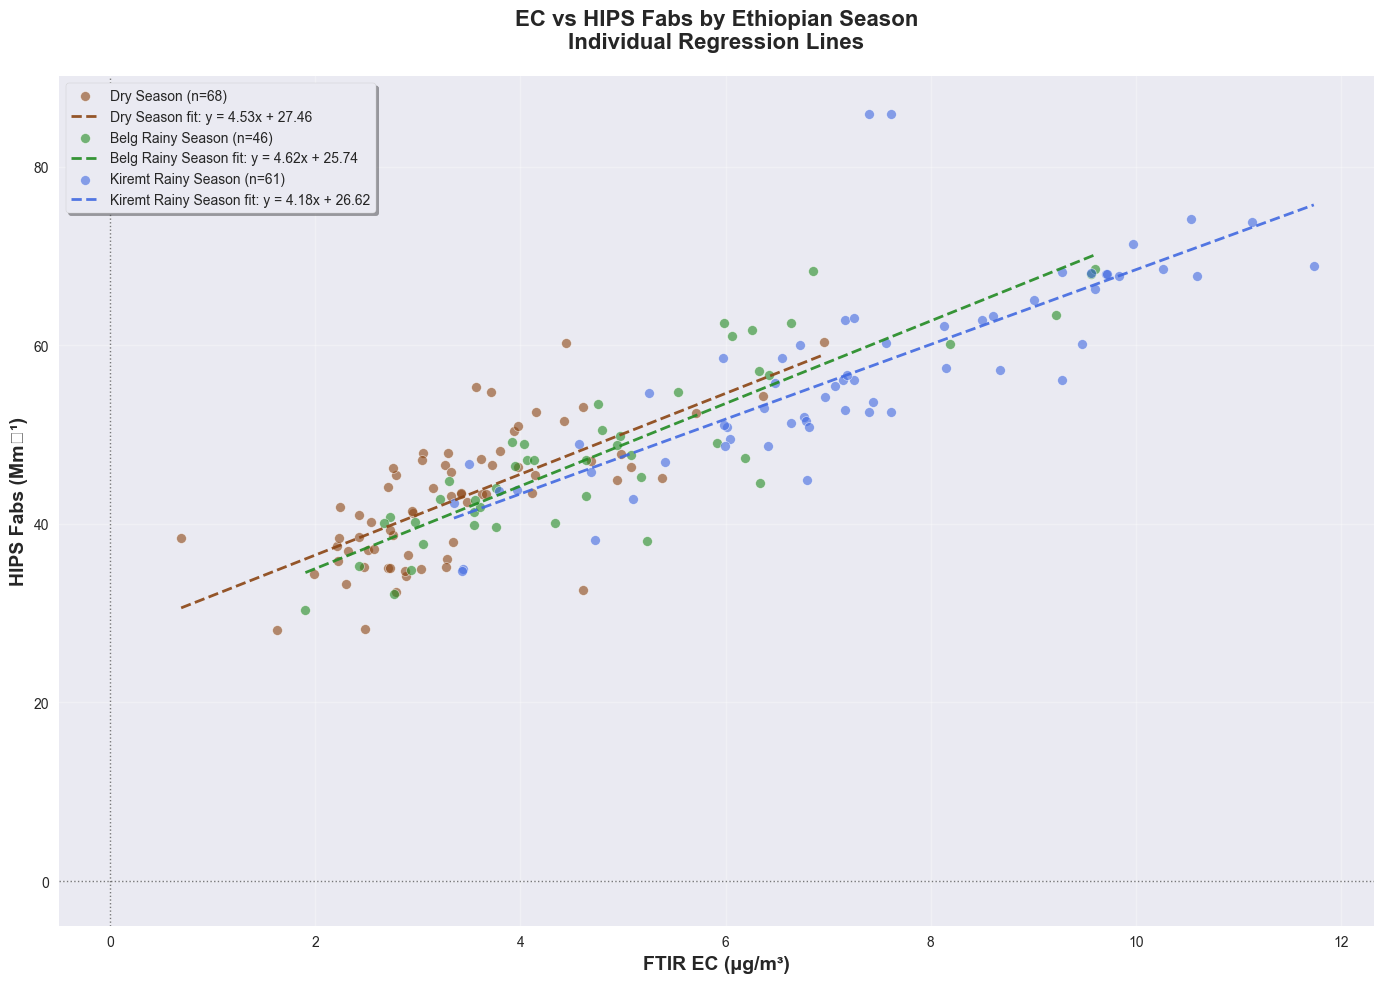


📈 Regression Results by Season:
--------------------------------------------------------------------------------
Season               Slope      Intercept    R²       n      Int/Mean(%) 
--------------------------------------------------------------------------------
Dry Season           4.526      27.456       0.474    68     64.2        
Belg Rainy Season    4.624      25.741       0.762    46     53.4        
Kiremt Rainy Season  4.185      26.620       0.635    61     46.8        

🎯 Key Findings:
   • Season with intercept closest to zero: Belg Rainy Season (intercept = 25.741 Mm⁻¹)
   • Season driving intercept away from zero: Dry Season (intercept = 27.456 Mm⁻¹)

💡 Physical Implications:
   • Dry Season: Positive intercept but negative EC crossing (physically valid range)
   • Belg Rainy Season: Positive intercept but negative EC crossing (physically valid range)
   • Kiremt Rainy Season: Positive intercept but negative EC crossing (physically valid range)

📐 Creating zoomed vi

TypeError: Axes.fill_between() got multiple values for argument 'where'

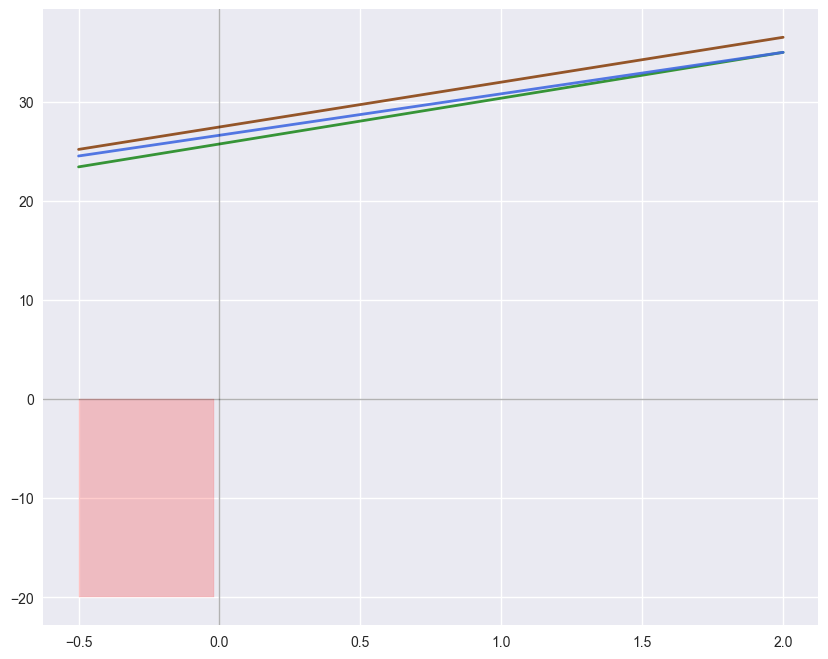

In [32]:
# %% [markdown]
# ## Seasonal EC vs HIPS Fabs Analysis with Individual Regression Lines
# 
# Investigating which season(s) drive the non-zero intercept issue in HIPS measurements.

# %%
# Seasonal EC vs HIPS Fabs with separate regression lines
print("📊 Seasonal Analysis: EC vs HIPS Fabs with Individual Regression Lines")
print("=" * 70)

if 'HIPS_Fabs' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    
    # Filter for valid data
    analysis_mask = matched_data[['HIPS_Fabs', 'EC_ftir']].notna().all(axis=1)
    analysis_data = matched_data[analysis_mask].copy()
    
    if len(analysis_data) > 0:
        
        # Add Ethiopian season if not already present
        if 'Ethiopian_Season' not in analysis_data.columns:
            analysis_data['month'] = analysis_data['datetime_local'].dt.month
            analysis_data['Ethiopian_Season'] = analysis_data['month'].apply(
                lambda m: 'Dry Season' if m in [10, 11, 12, 1, 2] else
                         'Belg Rainy Season' if m in [3, 4, 5] else
                         'Kiremt Rainy Season'
            )
        
        # Define season colors and order
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        season_colors = {'Dry Season': '#8B4513', 'Belg Rainy Season': '#228B22', 'Kiremt Rainy Season': '#4169E1'}
        
        # Create the main plot
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Store regression results
        regression_results = {}
        
        # Plot each season with its own regression line
        for season in seasons_order:
            season_data = analysis_data[analysis_data['Ethiopian_Season'] == season]
            
            if len(season_data) > 5:  # Need enough points for meaningful regression
                
                # Get data
                x = season_data['EC_ftir'].values
                y = season_data['HIPS_Fabs'].values
                
                # Calculate regression
                coeffs = np.polyfit(x, y, 1)
                slope, intercept = coeffs
                p = np.poly1d(coeffs)
                
                # Calculate R²
                y_pred = p(x)
                ss_res = np.sum((y - y_pred) ** 2)
                ss_tot = np.sum((y - np.mean(y)) ** 2)
                r2 = 1 - (ss_res / ss_tot)
                
                # Store results
                regression_results[season] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r2': r2,
                    'n': len(x),
                    'intercept_pct': (intercept / np.mean(y)) * 100 if np.mean(y) > 0 else 0
                }
                
                # Plot scatter points
                ax.scatter(x, y, alpha=0.6, s=50, 
                          color=season_colors.get(season, 'gray'),
                          label=f'{season} (n={len(x)})',
                          edgecolors='white', linewidth=0.5)
                
                # Plot regression line
                x_line = np.linspace(x.min(), x.max(), 100)
                ax.plot(x_line, p(x_line), '--', 
                       color=season_colors.get(season, 'gray'),
                       linewidth=2, alpha=0.9,
                       label=f'{season} fit: y = {slope:.2f}x + {intercept:.2f}')
        
        # Add zero reference lines
        ax.axhline(y=0, color='black', linestyle=':', alpha=0.5, linewidth=1)
        ax.axvline(x=0, color='black', linestyle=':', alpha=0.5, linewidth=1)
        
        # Formatting
        ax.set_xlabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
        ax.set_ylabel('HIPS Fabs (Mm⁻¹)', fontsize=14, fontweight='bold')
        ax.set_title('EC vs HIPS Fabs by Ethiopian Season\nIndividual Regression Lines',
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        
        # Set axis limits to show origin
        ax.set_xlim(left=-0.5)
        ax.set_ylim(bottom=-5)
        
        plt.tight_layout()
        plt.show()
        
        # Print regression results table
        print("\n📈 Regression Results by Season:")
        print("-" * 80)
        print(f"{'Season':<20} {'Slope':<10} {'Intercept':<12} {'R²':<8} {'n':<6} {'Int/Mean(%)':<12}")
        print("-" * 80)
        
        for season in seasons_order:
            if season in regression_results:
                r = regression_results[season]
                print(f"{season:<20} {r['slope']:<10.3f} {r['intercept']:<12.3f} "
                      f"{r['r2']:<8.3f} {r['n']:<6} {r['intercept_pct']:<12.1f}")
        
        # Identify the season with intercept closest to zero
        print("\n🎯 Key Findings:")
        
        # Find season with intercept closest to zero
        min_intercept_season = min(regression_results.keys(), 
                                   key=lambda k: abs(regression_results[k]['intercept']))
        max_intercept_season = max(regression_results.keys(), 
                                   key=lambda k: abs(regression_results[k]['intercept']))
        
        print(f"   • Season with intercept closest to zero: {min_intercept_season} "
              f"(intercept = {regression_results[min_intercept_season]['intercept']:.3f} Mm⁻¹)")
        print(f"   • Season driving intercept away from zero: {max_intercept_season} "
              f"(intercept = {regression_results[max_intercept_season]['intercept']:.3f} Mm⁻¹)")
        
        # Calculate physical implications
        print("\n💡 Physical Implications:")
        for season in seasons_order:
            if season in regression_results:
                r = regression_results[season]
                if r['intercept'] > 0:
                    # Calculate EC value where line crosses zero
                    ec_at_zero = -r['intercept'] / r['slope'] if r['slope'] != 0 else np.inf
                    if ec_at_zero > 0:
                        print(f"   • {season}: Predicts Fabs = 0 when EC = {ec_at_zero:.3f} μg/m³")
                        print(f"     (Violates physical constraint: should be Fabs = 0 when EC = 0)")
                    else:
                        print(f"   • {season}: Positive intercept but negative EC crossing (physically valid range)")
                else:
                    print(f"   • {season}: Negative intercept - predicts negative Fabs at low EC (non-physical)")
        
        # Create a zoomed-in plot near the origin
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        
        print("\n📐 Creating zoomed view near origin...")
        
        # Plot regression lines near origin
        x_zoom = np.linspace(-0.5, 2, 100)
        
        for season in seasons_order:
            if season in regression_results:
                r = regression_results[season]
                y_zoom = r['slope'] * x_zoom + r['intercept']
                
                ax2.plot(x_zoom, y_zoom, '-', 
                        color=season_colors.get(season, 'gray'),
                        linewidth=2, alpha=0.9,
                        label=f"{season}: y = {r['slope']:.2f}x + {r['intercept']:.2f}")
        
        # Add reference lines
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        
        # Add shaded region for non-physical area
        ax2.fill_between(x_zoom, -20, 0, where=(x_zoom <= 0), alpha=0.2, color='red',
                         label='Non-physical region (EC < 0)')
        ax2.fill_between([-0.5, 2], -20, -20, 0, where=([True, True]), alpha=0.2, color='orange',
                         label='Non-physical region (Fabs < 0)')
        
        # Add physical expectation point
        ax2.scatter([0], [0], s=200, marker='*', color='gold', edgecolor='black', 
                   linewidth=2, zorder=5, label='Physical expectation (0,0)')
        
        ax2.set_xlim(-0.5, 2)
        ax2.set_ylim(-5, 20)
        ax2.set_xlabel('FTIR EC (μg/m³)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('HIPS Fabs (Mm⁻¹)', fontsize=12, fontweight='bold')
        ax2.set_title('Zoomed View: Regression Lines Near Origin\nChecking Physical Constraints',
                     fontsize=14, fontweight='bold', pad=20)
        ax2.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary recommendations
        print("\n✅ Analysis Complete!")
        print("\n📝 Recommendations:")
        print("   1. Consider season-specific MAC values rather than a single annual value")
        print("   2. Investigate physical causes for non-zero intercepts:")
        print("      - Possible baseline absorption from non-EC sources")
        print("      - Instrumental artifacts at low concentrations")
        print("      - Seasonal composition differences affecting absorption")
        print("   3. Focus on understanding the", max_intercept_season, "high intercept")
        
    else:
        print("❌ No valid HIPS Fabs and EC data for analysis")
        
else:
    print("❌ HIPS_Fabs or EC_ftir columns not found in dataset")

print("\n" + "=" * 70)